
## Lane Finding

The code below aims to provide lane assistance / lane markings for autonomous cars.

### Steps
1. Calibrate Camera.
2. Generate Binary Threshold.
3. Warp image
4. Identify Lane Lines and draw on Warped image
5. Calculate curvature
6. Unwarp the image and merge with undistorted image


### Importing Modules

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import glob
%matplotlib inline

### PreprocessImage

The PreprocessImage provides following functionality.

* Calibrate Camera Helper Functions
* Undistort Image on calibration parameters

In [2]:
#Chessboard dimension contants in X and Y direction
_NX_CHESSBOARD = 9
_NY_CHESSBOARD = 6

class PreprocessImage:
    """
    This module preprocesses the image.
    It provides helper function to calibrate the camera.
    """
    def __init__(self, nx, ny):
        self.nx = nx
        self.ny = ny
        self.obj_points = []
        self.img_points = []
        self.objp = np.zeros((self.nx * self.ny, 3) , np.float32)
        self.objp[:,:2] = np.mgrid[0:self.nx, 0:self.ny].T.reshape(-1,2)
       

    def populate_calibration_points(self, img, drawImage=False):
        """
        This function should be recursively called on chessboard images to calibrate the camera
        """
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (self.nx, self.ny), None)
        if (ret == True):
            self.img_points.append(corners)
            self.obj_points.append(self.objp)

            if drawImage:
                print("Display corners")
                img_drawn_corner = cv2.drawChessboardCorners(img, (self.nx, self.ny), corners, ret)
                plt.imshow(img_drawn_corner)
                plt.show()
    
    def calibrate_camera(self, img):
        """
        Generates calibration parameters after the sufficient chess board images are read
        """
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.obj_points, 
                                                                                    self.img_points, 
                                                                                    gray.shape[::-1], 
                                                                                    None, 
                                                                                    None)
        return
    
    def undistort_image(self, img):
        """
        Undistort an image
        """
        return cv2.undistort(img, self.mtx, self.dist,None, self.mtx)
    


### Generate Calibration Points

In [47]:
calibrationObj_test = PreprocessImage(_NX_CHESSBOARD, _NY_CHESSBOARD)

#Loop through chessboard images to generate calibration parameters
for files in glob.glob('camera_cal\*.jpg'):
    img  = cv2.imread(files)
    calibrationObj_test.populate_calibration_points(img, False)

#Calibrate Camera after sufficient calibration images are read
calibrationObj_test.calibrate_camera(img)

img  = cv2.imread('camera_cal\calibration5.jpg')
out_img = calibrationObj_test.undistort_image(img)
cv2.imwrite("output_images/undistortedImage.jpg", out_img)

True

### Generate Threshold Image and Warp Image

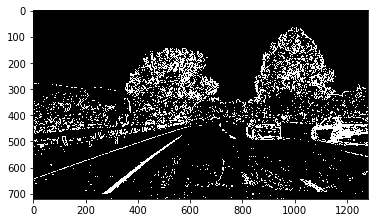

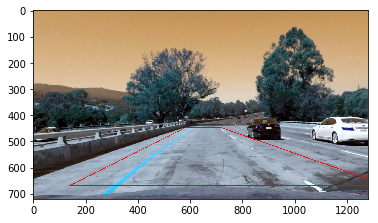

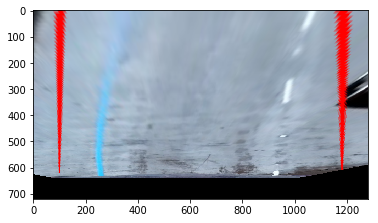

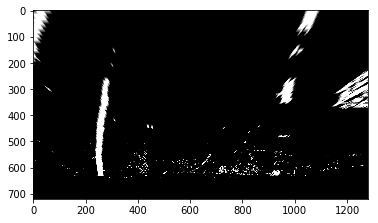

In [63]:

class WarpImage():
    """
    Provides helper functions to Warp and Unwarp an image
    """
    def __init__(self, img_size):
        offset = 100
        src = np.float32([[552,462], [760,462] , [1350,668],[140,668]])
        
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])
        #Parameter to warp an Image
        self.M = cv2.getPerspectiveTransform(src, dst)
        #Generate parameter to unwarp an image
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
    def create_warped(self, img):
        img_size = (img.shape[1], img.shape[0])
        warped = cv2.warpPerspective(img, self.M, img_size, flags=cv2.INTER_LINEAR)
        return warped  
    
    def create_unwarped(self, img):
        img_size = (img.shape[1], img.shape[0])
        unwarped = cv2.warpPerspective(img, self.Minv, img_size, flags=cv2.INTER_LINEAR)
        return unwarped  


def binary_threshold(img):
    """
    Applies sobel transform along with colour gradient to generate binary threshold
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1 , 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 15
    thresh_max = 255
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    #Find binary threshold on Color image in HLS format
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    thresh = (170, 255)
    #S Channel is better for thresholding
    S = hls[:,:,2]
    sbinary = np.zeros_like(S)
    sbinary[(S > thresh[0]) & (S <= thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(sbinary == 1) | (sxbinary == 1)] = 1
    return combined_binary

    
def test2():
    test_img = cv2.imread("test_images/test1.jpg")
    
    test_undst = calibrationObj_test.undistort_image(test_img)

    test_binary_img = binary_threshold(test_undst)
    #Plot the trapezoid on the image to fine tune image
    
    plt.imshow(test_binary_img, cmap='gray')

    out = np.zeros(test_binary_img.shape, np.double)
    normalized = cv2.normalize(test_binary_img, out, 255.0, 0.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    cv2.imwrite("output_images/binaryThreshold_test1.png", normalized)
    #[585,446], [715,446] , [1350,668],[140,668]]
    src = np.array([[(585,446),(715,446), (1350,668), (140,668)]], dtype = np.int32)
    roi_img = cv2.polylines(test_undst, src, True, (255, 0, 0), thickness = 2)
    plt.figure()
    plt.imshow(roi_img)
    plt.show()
    cv2.imwrite("output_images/roi.jpg", roi_img)
    
    test_warp_image_obj = WarpImage((test_img.shape[1], test_img.shape[0]))
    
    roi_warped  = test_warp_image_obj.create_warped(roi_img)
    plt.imshow(roi_warped)
    plt.show()
    cv2.imwrite("output_images/roi_warped.jpg", roi_warped)


    
    test_warped_image  = test_warp_image_obj.create_warped(normalized)
    plt.imshow(test_warped_image, cmap = 'gray')
    plt.show()
    
    cv2.imwrite("output_images/binaryThreshold_test1_warped.jpg", test_warped_image)

    
test2()


220
878


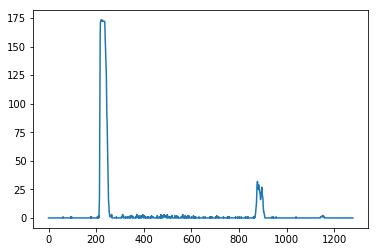

In [5]:

def hist(img):
    bottom_half = img[462:,:] #img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis = 0)
    return histogram

def test1():
    test_img = cv2.imread("test_images/straight_lines1.jpg")
    test_undst = calibrationObj_test.undistort_image(test_img)

    test_binary_img = binary_threshold(test_undst)

    test_warp_image_obj = WarpImage((test_img.shape[1], test_img.shape[0]))
    test_warped_image  = test_warp_image_obj.create_warped(test_binary_img)
    test_histogram = hist(test_warped_image)
    plt.plot(test_histogram)

    test_midpoint = np.int(test_histogram.shape[0]//2)
    test_leftx_base = np.argmax(test_histogram[:test_midpoint])
    test_rightx_base = np.argmax(test_histogram[test_midpoint:]) + test_midpoint
    
    if (test_rightx_base - test_leftx_base) > 900:
        print("Redjust the base")
        if test_histogram[test_leftx_base] > test_histogram[test_rightx_base]:
            dummy_start = np.int(test_leftx_base + 550)
            dummy_midpoint = (dummy_start + test_histogram.shape[0]) // 2
            test_rightx_base = dummy_start + np.argmax(test_histogram[test_leftx_base + 550:dummy_midpoint])
        

    print(test_leftx_base)
    print(test_rightx_base)

test1()




    

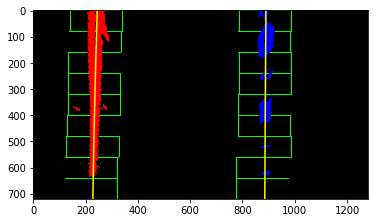

In [59]:
def adjust_base_pixels(histogram, leftx_base, rightx_base):
    max_lane_width = 900
    min_lane_width = 640
    if (((rightx_base - leftx_base) > max_lane_width) or ((rightx_base - leftx_base) < min_lane_width)):
        if histogram[leftx_base] > histogram[rightx_base]:
            #As pixels at leftx_base are more, use leftx base as reference
            dummy_start = np.int(leftx_base + min_lane_width)
            dummy_midpoint = (dummy_start + histogram.shape[0]) // 2
            rightx_base = dummy_start + np.argmax(histogram[dummy_start:dummy_midpoint]) 
        else:
            #As pixels at rightx_base are more, use leftx base as reference
            dummy_start = np.int(rightx_base - min_lane_width)
            dummy_midpoint = (dummy_start) // 2
            leftx_base = np.argmax(histogram[:dummy_midpoint]) 
    return leftx_base, rightx_base

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = []
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    dummy_hist = histogram[midpoint:]
    rightx_base = np.argmax(dummy_hist) + midpoint
       
    leftx_base, rightx_base = adjust_base_pixels(histogram, leftx_base, rightx_base)
    

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    #plt.imshow(out_img)
    #plt.show()
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img



def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    #print(left_fit)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        #print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

def test3():
    test_img = cv2.imread("test_images/straight_lines1.jpg")
    test_undst = calibrationObj_test.undistort_image(test_img)

    test_binary_img = binary_threshold(test_undst)

    #plt.imshow(test_binary_img, cmap='gray')
    #plt.show()

    test_warp_image_obj = WarpImage((test_img.shape[1], test_img.shape[0]))
    test_warped_image  = test_warp_image_obj.create_warped(test_binary_img)
    test_out_img = fit_polynomial(test_warped_image)

    plt.imshow(test_out_img)
    cv2.imwrite("output_images/drawn_lines.jpg", test_out_img)

test3()

929
205


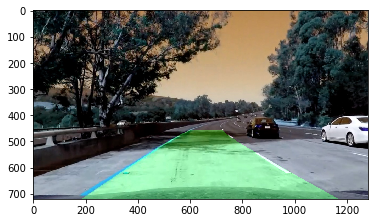

In [12]:
def test_draw_lane( warp_image_obj, test_undst, test_warped_image):
    
    test_warp_zero = np.zeros_like(test_warped_image).astype(np.uint8)
    test_color_warp = np.dstack((test_warp_zero, test_warp_zero, test_warp_zero))

    test_leftx, test_lefty, test_rightx, test_righty, test_out_img = find_lane_pixels(test_warped_image)
    # Fit a second order polynomial to each using `np.polyfit`
    test_left_fit = np.polyfit(test_lefty, test_leftx, 2)
    test_right_fit = np.polyfit(test_righty, test_rightx, 2)

    # Generate x and y values for plotting
    test_ploty = np.linspace(0, test_warped_image.shape[0]-1, test_warped_image.shape[0] )
    #try:
    test_left_fitx = test_left_fit[0]*test_ploty**2 + test_left_fit[1]*test_ploty + test_left_fit[2]
    test_right_fitx = test_right_fit[0]*test_ploty**2 + test_right_fit[1]*test_ploty + test_right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    test_pts_left = np.array([np.transpose(np.vstack([test_left_fitx, test_ploty]))])
    test_pts_right = np.array([np.flipud(np.transpose(np.vstack([test_right_fitx, test_ploty])))])
    test_pts = np.hstack((test_pts_left, test_pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(test_color_warp, np.int_([test_pts]), (0,255, 0))


    test_newwarp = warp_image_obj.create_unwarped(test_color_warp)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    #newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(test_undst, 1, test_newwarp, 0.3, 0)
    return result
    
def test4():
    test_img = cv2.imread("test_images/test5.jpg")
    test_undst = calibrationObj_test.undistort_image(test_img)

    test_binary_img = binary_threshold(test_undst)

    #plt.imshow(test_binary_img, cmap='gray')
    #plt.show()

    test_warp_image_obj = WarpImage((test_img.shape[1], test_img.shape[0]))
    test_warped_image  = test_warp_image_obj.create_warped(test_binary_img)
    plt.imshow(test_draw_lane(test_warp_image_obj, test_undst, test_warped_image))
    #plt.imshow(result)
    plt.show()
    
test4()

In [40]:
class Lines():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  
        self.ym_per_pix = 30/720 # meters per pixel in y dimension
        self.xm_per_pix = 3.7/700 # meters per pixel in x dimension
        
    def getBasePosition(self):
        return self.line_base_pos
    
    def setBasePosition(self, basePosition):
        self.line_base_pos = basePosition
        
    def fitLine(self, img,warped_img):
        self.current_fit = np.polyfit(self.ally, self.allx, 2)
        self.best_fit = self.current_fit
        self.line_base_pos = ((img.shape[1]) //2 - self.getFit(img.shape[0])) * self.xm_per_pix
        
        ## Visualization ##
        # Colors in the left and right lane regions
        #img[self.ally, self.allx] = [255, 0, 0]
        #out_img[righty, rightx] = [0, 0, 255]
        #print(self.ally)
        #print(self.allx)
        # Plots the left and right polynomials on the lane lines
        #ploty = np.linspace(0, warped_img.shape[0] - 1, warped_img.shape[1])
        #print(ploty)
        #left_fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2]
        #plt.plot(left_fitx, ploty, color='yellow')
        #plt.plot(right_fitx, ploty, color='yellow')
        #print(self.current_fit)
        #plt.imshow(img)
        #plt.show()
        return
        
    def calcCurvature(self, y_eval):
        """
        Calculate Radius of Curvature
        """
        #y_eval = np.max(self.ally)
        self.radius_of_curvature = ((1 + (2*self.best_fit[0]*y_eval*self.ym_per_pix + self.best_fit[1])**2)**1.5) / np.absolute(2*self.best_fit[0])
        return self.radius_of_curvature
    
    def getCurvature(self):
        """
        Get current Radius of curvature
        """
        return self.radius_of_curvature
    
    def getFit(self, ploty):
        try:
            fitx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            fitx  = 1*ploty**2 + 1*ploty
        
        return fitx
        


In [41]:
class DemarcateLanes:
    def __init__(self, path):
        # Conversions in x and y from pixels space to meters
        self.imgcenter = 0
        self.left = Lines()
        self.right = Lines()
        
        #Calibrate the Camera
        self.calibrationObj = PreprocessImage(9,6)
        img = None
        for files in glob.glob(path):
            img  = cv2.imread(files)
            self.calibrationObj.populate_calibration_points(img, False)        
        self.calibrationObj.calibrate_camera(img)
        
        #Generate warping and unwarping factor
        self.warp_image_obj = WarpImage((img.shape[1], img.shape[0]))
        self.detected = 0
        self.line_base_pos = None
    
    def drawLanes(self, img):
        undistorted_image = self.calibrationObj.undistort_image(img)
        bin_thres_img = binary_threshold(undistorted_image)
        warped_image  = self.warp_image_obj.create_warped(bin_thres_img)
        #plt.imshow(warped_image, cmap='gray')
        #plt.show()       
        
        if (self.detected == False):
            #self.detected = True
            self.imgcenter = img.shape[1] // 2
            out_img = self.drawLanes_firstImage(warped_image)
        else:
            out_img = self.drawLanes_subsequentImage(warped_image)
            
        left_curve, right_curve = self.measure_curvature_real()
        self.line_base_pos = self.left.getBasePosition() - self.right.getBasePosition()
        
        out_img = self.plot(warped_image, undistorted_image)
            
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (10,30)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        
        cv2.putText(out_img,'Radius of Curvature(Left)  = ' + str((left_curve)), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)   
        
        bottomLeftCornerOfText = (10, 70)
        
        cv2.putText(out_img,'Radius of Curvature(Right) = ' + str((right_curve)), 
            bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType) 
        
        bottomLeftCornerOfText = (10,110)
        cv2.putText(out_img,'Distance from center   = ' + str(self.line_base_pos), bottomLeftCornerOfText, 
            font, 
            fontScale,
            fontColor,
            lineType)    
            
        return out_img
        
    def plot(self, warped_image, undistorted_img):
        warp_zero = np.zeros_like(warped_image).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        
        ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
        left_fitx = self.left.getFit(ploty)
        right_fitx = self.right.getFit(ploty)
        
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
        newwarp = self.warp_image_obj.create_unwarped(color_warp)
        result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
        return result
        
    def drawLanes_firstImage(self, warped_image):
        
        self.left.allx, self.left.ally, self.right.allx, self.right.ally, out_img = find_lane_pixels(warped_image)
        
        self.left.fitLine(out_img, warped_image)
        self.right.fitLine(out_img, warped_image)
        
        self.ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
        left_fitx = self.left.getFit(self.ploty)
        right_fitx = self.right.getFit(self.ploty)
            
        return

    def drawLanes_subsequentImage(self , binary_warped ):
        # HYPERPARAMETER
        # Width of the margin around the previous polynomial to search
        margin = 100

        # Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

    
        left_lane_inds = (((nonzerox > self.left.getFit(nonzeroy) - margin)) & 
                          (nonzerox < (self.left.getFit(nonzeroy) + margin)))
        right_lane_inds = ((nonzerox > (self.right.getFit(nonzeroy) - margin)) & 
                           (nonzerox < (self.right.getFit(nonzeroy) + margin)))

        # Again, extract left and right line pixel positions
        self.left.allx = nonzerox[left_lane_inds]
        self.left.ally = nonzeroy[left_lane_inds] 
        self.right.allx = nonzerox[right_lane_inds]
        self.right.ally = nonzeroy[right_lane_inds]
        
        self.left.fitLine()
        self.right.fitLine()
        
        return
    
    def measure_curvature_real(self):
        '''
        Calculates the curvature of polynomial functions in meters.
        '''       
        # Define y-value where we want radius of curvature
        # We'll choose the maximum y-value, corresponding to the bottom of the image
        y_eval = np.max(self.ploty)

        # Calculation of R_curve (radius of curvature)
        left_curverad = self.left.calcCurvature(y_eval)
        right_curverad = self.right.calcCurvature(y_eval)
        return left_curverad, right_curverad
    
    def measure_offset_real(self):
        """
        Calculate the offset of the vehicle with center
        """        
        lane_center = (self.right.getBasePosition() + self.left.getBasePosition()) // 2
        
        if (self.imgcenter > lane_center):            
            return (self.imgcenter - lane_center) * self.xm_per_pix
        
        return (lane_center - self.imgcenter) * self.xm_per_pix    

In [42]:
drawEngine = DemarcateLanes('camera_cal\*.jpg')
'''
image = cv2.imread("test_images/test4.jpg")
out_img = drawEngine.drawLanes_firstImage(image)
cv2.imwrite("output_images/"+ file, out_img)
'''

for file in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + file)
    out_img = drawEngine.drawLanes(image)
    cv2.imwrite("output_images/"+ file, out_img)


878
222
902
223
930
259
945
278
931
279
943
279
929
204
967
299


In [43]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [44]:
drawEngine = DemarcateLanes('camera_cal\*.jpg')
def process_image(image):    
    #img = drawEngine.drawLanes_firstImage()
    out_img = drawEngine.drawLanes(image)
    left_curve, right_curve = drawEngine.measure_curvature_real()
    return out_img
    #cv2.imwrite("output_images/"+ file, out_img)


In [45]:
white_output = 'output_images/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
input_video = "project_video.mp4"
clip1 = VideoFileClip(input_video)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)




953
274
[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


  0%|                                                                                         | 0/1261 [00:00<?, ?it/s]

953
274


  0%|                                                                                 | 1/1261 [00:00<02:53,  7.26it/s]

957
276


  0%|▏                                                                                | 2/1261 [00:00<02:50,  7.36it/s]

955
276


  0%|▏                                                                                | 3/1261 [00:00<02:49,  7.43it/s]

950
272


  0%|▎                                                                                | 4/1261 [00:00<02:49,  7.39it/s]

959
273


  0%|▎                                                                                | 5/1261 [00:00<02:53,  7.25it/s]

944
275


  0%|▍                                                                                | 6/1261 [00:00<02:51,  7.34it/s]

933
284


  1%|▍                                                                                | 7/1261 [00:00<02:49,  7.39it/s]

933
278


  1%|▌                                                                                | 8/1261 [00:01<02:49,  7.39it/s]

937
278


  1%|▌                                                                                | 9/1261 [00:01<02:51,  7.29it/s]

943
279


  1%|▋                                                                               | 10/1261 [00:01<02:48,  7.41it/s]

945
278


  1%|▋                                                                               | 11/1261 [00:01<02:46,  7.51it/s]

951
275


  1%|▊                                                                               | 12/1261 [00:01<02:47,  7.46it/s]

953
276


  1%|▊                                                                               | 13/1261 [00:01<02:46,  7.50it/s]

937
276


  1%|▉                                                                               | 14/1261 [00:01<02:45,  7.52it/s]

937
276


  1%|▉                                                                               | 15/1261 [00:02<02:48,  7.41it/s]

937
277


  1%|█                                                                               | 16/1261 [00:02<02:53,  7.19it/s]

937
276


  1%|█                                                                               | 17/1261 [00:02<02:54,  7.13it/s]

938
276


  1%|█▏                                                                              | 18/1261 [00:02<02:51,  7.24it/s]

910
273


  2%|█▏                                                                              | 19/1261 [00:02<02:58,  6.96it/s]

914
273


  2%|█▎                                                                              | 20/1261 [00:02<02:59,  6.92it/s]

919
272


  2%|█▎                                                                              | 21/1261 [00:02<02:52,  7.20it/s]

931
272


  2%|█▍                                                                              | 22/1261 [00:02<02:46,  7.46it/s]

939
268


  2%|█▍                                                                              | 23/1261 [00:03<02:42,  7.61it/s]

937
263


  2%|█▌                                                                              | 24/1261 [00:03<02:39,  7.77it/s]

937
266


  2%|█▌                                                                              | 25/1261 [00:03<02:37,  7.85it/s]

924
265


  2%|█▋                                                                              | 26/1261 [00:03<02:41,  7.66it/s]

937
263


  2%|█▋                                                                              | 27/1261 [00:03<02:44,  7.48it/s]

943
260


  2%|█▊                                                                              | 28/1261 [00:03<02:46,  7.40it/s]

943
260


  2%|█▊                                                                              | 29/1261 [00:03<02:46,  7.39it/s]

939
263


  2%|█▉                                                                              | 30/1261 [00:04<02:59,  6.86it/s]

947
261


  2%|█▉                                                                              | 31/1261 [00:04<02:54,  7.04it/s]

917
260


  3%|██                                                                              | 32/1261 [00:04<02:51,  7.19it/s]

928
258


  3%|██                                                                              | 33/1261 [00:04<02:47,  7.33it/s]

929
259


  3%|██▏                                                                             | 34/1261 [00:04<02:51,  7.15it/s]

933
261


  3%|██▏                                                                             | 35/1261 [00:04<02:53,  7.07it/s]

934
263


  3%|██▎                                                                             | 36/1261 [00:04<02:51,  7.15it/s]

936
265


  3%|██▎                                                                             | 37/1261 [00:05<02:46,  7.37it/s]

919
266


  3%|██▍                                                                             | 38/1261 [00:05<02:46,  7.35it/s]

920
268


  3%|██▍                                                                             | 39/1261 [00:05<02:48,  7.27it/s]

925
266


  3%|██▌                                                                             | 40/1261 [00:05<02:49,  7.22it/s]

932
269


  3%|██▌                                                                             | 41/1261 [00:05<02:51,  7.13it/s]

933
268


  3%|██▋                                                                             | 42/1261 [00:05<02:48,  7.22it/s]

941
271


  3%|██▋                                                                             | 43/1261 [00:05<02:56,  6.88it/s]

918
271


  3%|██▊                                                                             | 44/1261 [00:06<02:58,  6.81it/s]

924
269


  4%|██▊                                                                             | 45/1261 [00:06<03:05,  6.57it/s]

923
269


  4%|██▉                                                                             | 46/1261 [00:06<03:06,  6.51it/s]

930
267


  4%|██▉                                                                             | 47/1261 [00:06<03:06,  6.51it/s]

932
268


  4%|███                                                                             | 48/1261 [00:06<03:08,  6.45it/s]

940
267


  4%|███                                                                             | 49/1261 [00:06<03:05,  6.53it/s]

943
268


  4%|███▏                                                                            | 50/1261 [00:06<03:03,  6.61it/s]

926
268


  4%|███▏                                                                            | 51/1261 [00:07<03:01,  6.66it/s]

927
269


  4%|███▎                                                                            | 52/1261 [00:07<03:02,  6.61it/s]

929
269


  4%|███▎                                                                            | 53/1261 [00:07<03:04,  6.56it/s]

933
269


  4%|███▍                                                                            | 54/1261 [00:07<03:00,  6.68it/s]

935
269


  4%|███▍                                                                            | 55/1261 [00:07<02:59,  6.73it/s]

939
269


  4%|███▌                                                                            | 56/1261 [00:07<02:59,  6.70it/s]

914
268


  5%|███▌                                                                            | 57/1261 [00:08<03:03,  6.56it/s]

915
267


  5%|███▋                                                                            | 58/1261 [00:08<03:00,  6.68it/s]

895
267


  5%|███▋                                                                            | 59/1261 [00:08<02:59,  6.70it/s]

894
269


  5%|███▊                                                                            | 60/1261 [00:08<02:59,  6.68it/s]

898
266


  5%|███▊                                                                            | 61/1261 [00:08<02:59,  6.70it/s]

900
267


  5%|███▉                                                                            | 62/1261 [00:08<03:01,  6.61it/s]

909
265


  5%|███▉                                                                            | 63/1261 [00:08<03:03,  6.52it/s]

913
266


  5%|████                                                                            | 64/1261 [00:09<03:04,  6.47it/s]

915
265


  5%|████                                                                            | 65/1261 [00:09<03:03,  6.51it/s]

918
263


  5%|████▏                                                                           | 66/1261 [00:09<03:03,  6.51it/s]

921
260


  5%|████▎                                                                           | 67/1261 [00:09<03:03,  6.51it/s]

922
259


  5%|████▎                                                                           | 68/1261 [00:09<03:00,  6.60it/s]

862
258


  5%|████▍                                                                           | 69/1261 [00:09<03:01,  6.58it/s]

871
257


  6%|████▍                                                                           | 70/1261 [00:10<03:01,  6.58it/s]

874
255


  6%|████▌                                                                           | 71/1261 [00:10<02:52,  6.88it/s]

882
253


  6%|████▌                                                                           | 72/1261 [00:10<02:54,  6.83it/s]

884
252


  6%|████▋                                                                           | 73/1261 [00:10<02:55,  6.78it/s]

888
252


  6%|████▋                                                                           | 74/1261 [00:10<02:57,  6.70it/s]

900
250


  6%|████▊                                                                           | 75/1261 [00:10<02:59,  6.62it/s]

898
251


  6%|████▊                                                                           | 76/1261 [00:10<02:58,  6.63it/s]

905
249


  6%|████▉                                                                           | 77/1261 [00:11<02:54,  6.78it/s]

909
248


  6%|████▉                                                                           | 78/1261 [00:11<02:54,  6.77it/s]

917
247


  6%|█████                                                                           | 79/1261 [00:11<02:58,  6.62it/s]

924
247


  6%|█████                                                                           | 80/1261 [00:11<02:59,  6.57it/s]

910
245


  6%|█████▏                                                                          | 81/1261 [00:11<02:58,  6.61it/s]

910
243


  7%|█████▏                                                                          | 82/1261 [00:11<03:00,  6.52it/s]

911
241


  7%|█████▎                                                                          | 83/1261 [00:11<02:58,  6.61it/s]

914
239


  7%|█████▎                                                                          | 84/1261 [00:12<02:58,  6.61it/s]

920
238


  7%|█████▍                                                                          | 85/1261 [00:12<03:01,  6.47it/s]

922
236


  7%|█████▍                                                                          | 86/1261 [00:12<03:02,  6.43it/s]

919
240


  7%|█████▌                                                                          | 87/1261 [00:12<02:59,  6.56it/s]

913
240


  7%|█████▌                                                                          | 88/1261 [00:12<02:59,  6.54it/s]

918
240


  7%|█████▋                                                                          | 89/1261 [00:12<03:01,  6.45it/s]

900
240


  7%|█████▋                                                                          | 90/1261 [00:13<02:59,  6.53it/s]

913
240


  7%|█████▊                                                                          | 91/1261 [00:13<02:59,  6.52it/s]

917
242


  7%|█████▊                                                                          | 92/1261 [00:13<02:58,  6.54it/s]

909
242


  7%|█████▉                                                                          | 93/1261 [00:13<02:57,  6.59it/s]

890
243


  7%|█████▉                                                                          | 94/1261 [00:13<02:58,  6.56it/s]

890
242


  8%|██████                                                                          | 95/1261 [00:13<02:54,  6.67it/s]

897
242


  8%|██████                                                                          | 96/1261 [00:13<02:57,  6.55it/s]

901
242


  8%|██████▏                                                                         | 97/1261 [00:14<02:55,  6.62it/s]

907
242


  8%|██████▏                                                                         | 98/1261 [00:14<02:53,  6.69it/s]

909
244


  8%|██████▎                                                                         | 99/1261 [00:14<02:55,  6.64it/s]

912
244


  8%|██████▎                                                                        | 100/1261 [00:14<02:54,  6.65it/s]

896
245


  8%|██████▎                                                                        | 101/1261 [00:14<02:54,  6.63it/s]

897
247


  8%|██████▍                                                                        | 102/1261 [00:14<02:53,  6.68it/s]

904
248


  8%|██████▍                                                                        | 103/1261 [00:14<02:55,  6.59it/s]

908
253


  8%|██████▌                                                                        | 104/1261 [00:15<02:54,  6.63it/s]

908
249


  8%|██████▌                                                                        | 105/1261 [00:15<02:52,  6.72it/s]

911
250


  8%|██████▋                                                                        | 106/1261 [00:15<02:49,  6.83it/s]

915
251


  8%|██████▋                                                                        | 107/1261 [00:15<02:48,  6.85it/s]

917
253


  9%|██████▊                                                                        | 108/1261 [00:15<02:46,  6.94it/s]

916
252


  9%|██████▊                                                                        | 109/1261 [00:15<02:47,  6.88it/s]

919
253


  9%|██████▉                                                                        | 110/1261 [00:16<02:49,  6.81it/s]

922
256


  9%|██████▉                                                                        | 111/1261 [00:16<02:47,  6.88it/s]

934
253


  9%|███████                                                                        | 112/1261 [00:16<02:45,  6.93it/s]

927
254


  9%|███████                                                                        | 113/1261 [00:16<02:47,  6.85it/s]

915
256


  9%|███████▏                                                                       | 114/1261 [00:16<02:44,  6.98it/s]

916
257


  9%|███████▏                                                                       | 115/1261 [00:16<02:50,  6.73it/s]

918
257


  9%|███████▎                                                                       | 116/1261 [00:16<02:49,  6.74it/s]

933
257


  9%|███████▎                                                                       | 117/1261 [00:17<02:48,  6.77it/s]

928
258


  9%|███████▍                                                                       | 118/1261 [00:17<02:48,  6.79it/s]

922
259


  9%|███████▍                                                                       | 119/1261 [00:17<02:49,  6.75it/s]

908
261


 10%|███████▌                                                                       | 120/1261 [00:17<02:48,  6.77it/s]

916
262


 10%|███████▌                                                                       | 121/1261 [00:17<02:48,  6.75it/s]

917
264


 10%|███████▋                                                                       | 122/1261 [00:17<02:48,  6.76it/s]

922
265


 10%|███████▋                                                                       | 123/1261 [00:17<02:51,  6.62it/s]

926
268


 10%|███████▊                                                                       | 124/1261 [00:18<02:50,  6.66it/s]

927
269


 10%|███████▊                                                                       | 125/1261 [00:18<02:51,  6.62it/s]

934
271


 10%|███████▉                                                                       | 126/1261 [00:18<02:54,  6.52it/s]

918
268


 10%|███████▉                                                                       | 127/1261 [00:18<02:53,  6.55it/s]

923
269


 10%|████████                                                                       | 128/1261 [00:18<02:50,  6.64it/s]

925
272


 10%|████████                                                                       | 129/1261 [00:18<02:51,  6.59it/s]

927
271


 10%|████████▏                                                                      | 130/1261 [00:19<02:53,  6.51it/s]

930
272


 10%|████████▏                                                                      | 131/1261 [00:19<02:52,  6.54it/s]

909
276


 10%|████████▎                                                                      | 132/1261 [00:19<02:51,  6.59it/s]

914
273


 11%|████████▎                                                                      | 133/1261 [00:19<02:50,  6.63it/s]

917
275


 11%|████████▍                                                                      | 134/1261 [00:19<02:47,  6.73it/s]

922
276


 11%|████████▍                                                                      | 135/1261 [00:19<02:51,  6.56it/s]

918
281


 11%|████████▌                                                                      | 136/1261 [00:19<02:50,  6.62it/s]

921
281


 11%|████████▌                                                                      | 137/1261 [00:20<02:49,  6.62it/s]

925
277


 11%|████████▋                                                                      | 138/1261 [00:20<02:49,  6.64it/s]

929
277


 11%|████████▋                                                                      | 139/1261 [00:20<02:51,  6.54it/s]

933
273


 11%|████████▊                                                                      | 140/1261 [00:20<02:49,  6.61it/s]

938
273


 11%|████████▊                                                                      | 141/1261 [00:20<02:50,  6.57it/s]

939
273


 11%|████████▉                                                                      | 142/1261 [00:20<02:45,  6.74it/s]

938
274


 11%|████████▉                                                                      | 143/1261 [00:20<02:47,  6.66it/s]

939
273


 11%|█████████                                                                      | 144/1261 [00:21<02:47,  6.66it/s]

921
275


 11%|█████████                                                                      | 145/1261 [00:21<02:47,  6.66it/s]

918
273


 12%|█████████▏                                                                     | 146/1261 [00:21<02:46,  6.68it/s]

926
273


 12%|█████████▏                                                                     | 147/1261 [00:21<02:45,  6.74it/s]

923
273


 12%|█████████▎                                                                     | 148/1261 [00:21<02:46,  6.68it/s]

928
273


 12%|█████████▎                                                                     | 149/1261 [00:21<02:45,  6.71it/s]

913
273


 12%|█████████▍                                                                     | 150/1261 [00:22<02:45,  6.69it/s]

919
273


 12%|█████████▍                                                                     | 151/1261 [00:22<02:43,  6.78it/s]

922
275


 12%|█████████▌                                                                     | 152/1261 [00:22<02:44,  6.74it/s]

924
272


 12%|█████████▌                                                                     | 153/1261 [00:22<02:42,  6.81it/s]

930
270


 12%|█████████▋                                                                     | 154/1261 [00:22<02:40,  6.89it/s]

937
267


 12%|█████████▋                                                                     | 155/1261 [00:22<02:42,  6.80it/s]

934
267


 12%|█████████▊                                                                     | 156/1261 [00:22<02:41,  6.84it/s]

931
268


 12%|█████████▊                                                                     | 157/1261 [00:23<02:42,  6.79it/s]

916
269


 13%|█████████▉                                                                     | 158/1261 [00:23<02:43,  6.74it/s]

919
267


 13%|█████████▉                                                                     | 159/1261 [00:23<02:42,  6.79it/s]

921
265


 13%|██████████                                                                     | 160/1261 [00:23<02:42,  6.78it/s]

922
263


 13%|██████████                                                                     | 161/1261 [00:23<02:41,  6.82it/s]

933
259


 13%|██████████▏                                                                    | 162/1261 [00:23<02:40,  6.83it/s]

934
259


 13%|██████████▏                                                                    | 163/1261 [00:23<02:44,  6.67it/s]

920
258


 13%|██████████▎                                                                    | 164/1261 [00:24<02:45,  6.64it/s]

920
258


 13%|██████████▎                                                                    | 165/1261 [00:24<02:41,  6.77it/s]

922
260


 13%|██████████▍                                                                    | 166/1261 [00:24<02:40,  6.83it/s]

924
258


 13%|██████████▍                                                                    | 167/1261 [00:24<02:44,  6.63it/s]

931
257


 13%|██████████▌                                                                    | 168/1261 [00:24<02:45,  6.59it/s]

930
257


 13%|██████████▌                                                                    | 169/1261 [00:24<02:43,  6.66it/s]

908
253


 13%|██████████▋                                                                    | 170/1261 [00:24<02:41,  6.74it/s]

913
252


 14%|██████████▋                                                                    | 171/1261 [00:25<02:43,  6.66it/s]

918
251


 14%|██████████▊                                                                    | 172/1261 [00:25<02:42,  6.69it/s]

917
251


 14%|██████████▊                                                                    | 173/1261 [00:25<02:40,  6.77it/s]

919
251


 14%|██████████▉                                                                    | 174/1261 [00:25<02:38,  6.86it/s]

919
251


 14%|██████████▉                                                                    | 175/1261 [00:25<02:40,  6.75it/s]

902
251


 14%|███████████                                                                    | 176/1261 [00:25<02:43,  6.64it/s]

909
248


 14%|███████████                                                                    | 177/1261 [00:26<02:42,  6.66it/s]

915
247


 14%|███████████▏                                                                   | 178/1261 [00:26<02:39,  6.78it/s]

921
247


 14%|███████████▏                                                                   | 179/1261 [00:26<02:39,  6.79it/s]

924
247


 14%|███████████▎                                                                   | 180/1261 [00:26<02:40,  6.74it/s]

924
248


 14%|███████████▎                                                                   | 181/1261 [00:26<02:41,  6.71it/s]

925
246


 14%|███████████▍                                                                   | 182/1261 [00:26<02:37,  6.83it/s]

914
249


 15%|███████████▍                                                                   | 183/1261 [00:26<02:36,  6.88it/s]

916
250


 15%|███████████▌                                                                   | 184/1261 [00:27<02:36,  6.87it/s]

904
248


 15%|███████████▌                                                                   | 185/1261 [00:27<02:36,  6.86it/s]

902
251


 15%|███████████▋                                                                   | 186/1261 [00:27<02:39,  6.74it/s]

913
251


 15%|███████████▋                                                                   | 187/1261 [00:27<02:41,  6.66it/s]

910
253


 15%|███████████▊                                                                   | 188/1261 [00:27<02:43,  6.57it/s]

915
253


 15%|███████████▊                                                                   | 189/1261 [00:27<02:46,  6.44it/s]

920
254


 15%|███████████▉                                                                   | 190/1261 [00:27<02:44,  6.50it/s]

923
258


 15%|███████████▉                                                                   | 191/1261 [00:28<02:41,  6.64it/s]

934
269


 15%|████████████                                                                   | 192/1261 [00:28<02:38,  6.76it/s]

929
272


 15%|████████████                                                                   | 193/1261 [00:28<02:36,  6.82it/s]

872
264


 15%|████████████▏                                                                  | 194/1261 [00:28<02:38,  6.72it/s]

880
265


 15%|████████████▏                                                                  | 195/1261 [00:28<02:40,  6.63it/s]

894
265


 16%|████████████▎                                                                  | 196/1261 [00:28<02:39,  6.68it/s]

921
259


 16%|████████████▎                                                                  | 197/1261 [00:28<02:39,  6.69it/s]

934
255


 16%|████████████▍                                                                  | 198/1261 [00:29<02:39,  6.66it/s]

943
252


 16%|████████████▍                                                                  | 199/1261 [00:29<02:38,  6.70it/s]

943
251


 16%|████████████▌                                                                  | 200/1261 [00:29<02:37,  6.73it/s]

929
249


 16%|████████████▌                                                                  | 201/1261 [00:29<02:35,  6.83it/s]

930
248


 16%|████████████▋                                                                  | 202/1261 [00:29<02:35,  6.81it/s]

930
247


 16%|████████████▋                                                                  | 203/1261 [00:29<02:34,  6.87it/s]

936
246


 16%|████████████▊                                                                  | 204/1261 [00:30<02:35,  6.78it/s]

931
247


 16%|████████████▊                                                                  | 205/1261 [00:30<02:35,  6.78it/s]

932
248


 16%|████████████▉                                                                  | 206/1261 [00:30<02:36,  6.74it/s]

903
253


 16%|████████████▉                                                                  | 207/1261 [00:30<02:38,  6.63it/s]

886
255


 16%|█████████████                                                                  | 208/1261 [00:30<02:37,  6.68it/s]

901
253


 17%|█████████████                                                                  | 209/1261 [00:30<02:36,  6.72it/s]

904
252


 17%|█████████████▏                                                                 | 210/1261 [00:30<02:36,  6.73it/s]

929
251


 17%|█████████████▏                                                                 | 211/1261 [00:31<02:38,  6.64it/s]

930
251


 17%|█████████████▎                                                                 | 212/1261 [00:31<02:36,  6.70it/s]

933
251


 17%|█████████████▎                                                                 | 213/1261 [00:31<02:34,  6.79it/s]

918
250


 17%|█████████████▍                                                                 | 214/1261 [00:31<02:35,  6.74it/s]

919
249


 17%|█████████████▍                                                                 | 215/1261 [00:31<02:37,  6.66it/s]

923
250


 17%|█████████████▌                                                                 | 216/1261 [00:31<02:38,  6.60it/s]

923
247


 17%|█████████████▌                                                                 | 217/1261 [00:31<02:36,  6.66it/s]

922
245


 17%|█████████████▋                                                                 | 218/1261 [00:32<02:38,  6.56it/s]

897
244


 17%|█████████████▋                                                                 | 219/1261 [00:32<02:37,  6.60it/s]

897
242


 17%|█████████████▊                                                                 | 220/1261 [00:32<02:39,  6.53it/s]

893
243


 18%|█████████████▊                                                                 | 221/1261 [00:32<02:37,  6.61it/s]

894
245


 18%|█████████████▉                                                                 | 222/1261 [00:32<02:34,  6.71it/s]

897
245


 18%|█████████████▉                                                                 | 223/1261 [00:32<02:36,  6.62it/s]

897
247


 18%|██████████████                                                                 | 224/1261 [00:33<02:37,  6.58it/s]

902
246


 18%|██████████████                                                                 | 225/1261 [00:33<02:37,  6.56it/s]

902
246


 18%|██████████████▏                                                                | 226/1261 [00:33<02:36,  6.60it/s]

904
245


 18%|██████████████▏                                                                | 227/1261 [00:33<02:36,  6.60it/s]

907
243


 18%|██████████████▎                                                                | 228/1261 [00:33<02:37,  6.58it/s]

911
242


 18%|██████████████▎                                                                | 229/1261 [00:33<02:37,  6.56it/s]

914
240


 18%|██████████████▍                                                                | 230/1261 [00:33<02:34,  6.66it/s]

883
239


 18%|██████████████▍                                                                | 231/1261 [00:34<02:36,  6.56it/s]

890
237


 18%|██████████████▌                                                                | 232/1261 [00:34<02:33,  6.72it/s]

890
235


 18%|██████████████▌                                                                | 233/1261 [00:34<02:31,  6.77it/s]

894
234


 19%|██████████████▋                                                                | 234/1261 [00:34<02:34,  6.64it/s]

897
232


 19%|██████████████▋                                                                | 235/1261 [00:34<02:36,  6.55it/s]

897
230


 19%|██████████████▊                                                                | 236/1261 [00:34<02:36,  6.56it/s]

881
231


 19%|██████████████▊                                                                | 237/1261 [00:34<02:32,  6.70it/s]

884
230


 19%|██████████████▉                                                                | 238/1261 [00:35<02:32,  6.73it/s]

887
229


 19%|██████████████▉                                                                | 239/1261 [00:35<02:32,  6.70it/s]

891
228


 19%|███████████████                                                                | 240/1261 [00:35<02:31,  6.72it/s]

899
228


 19%|███████████████                                                                | 241/1261 [00:35<02:31,  6.74it/s]

903
224


 19%|███████████████▏                                                               | 242/1261 [00:35<02:45,  6.17it/s]

875
226


 19%|███████████████▏                                                               | 243/1261 [00:35<02:45,  6.17it/s]

880
224


 19%|███████████████▎                                                               | 244/1261 [00:36<02:44,  6.17it/s]

863
224


 19%|███████████████▎                                                               | 245/1261 [00:36<02:43,  6.23it/s]

873
223


 20%|███████████████▍                                                               | 246/1261 [00:36<02:39,  6.35it/s]

877
222


 20%|███████████████▍                                                               | 247/1261 [00:36<02:43,  6.20it/s]

878
225


 20%|███████████████▌                                                               | 248/1261 [00:36<02:39,  6.36it/s]

891
222


 20%|███████████████▌                                                               | 249/1261 [00:36<02:39,  6.35it/s]

878
225


 20%|███████████████▋                                                               | 250/1261 [00:37<02:38,  6.38it/s]

884
220


 20%|███████████████▋                                                               | 251/1261 [00:37<02:34,  6.52it/s]

889
220


 20%|███████████████▊                                                               | 252/1261 [00:37<02:30,  6.70it/s]

892
220


 20%|███████████████▊                                                               | 253/1261 [00:37<02:28,  6.77it/s]

902
220


 20%|███████████████▉                                                               | 254/1261 [00:37<02:28,  6.80it/s]

865
226


 20%|███████████████▉                                                               | 255/1261 [00:37<02:29,  6.72it/s]

860
221


 20%|████████████████                                                               | 256/1261 [00:37<02:28,  6.76it/s]

863
222


 20%|████████████████                                                               | 257/1261 [00:38<02:30,  6.68it/s]

865
226


 20%|████████████████▏                                                              | 258/1261 [00:38<02:27,  6.78it/s]

886
223


 21%|████████████████▏                                                              | 259/1261 [00:38<02:29,  6.69it/s]

891
225


 21%|████████████████▎                                                              | 260/1261 [00:38<02:31,  6.62it/s]

899
223


 21%|████████████████▎                                                              | 261/1261 [00:38<02:28,  6.73it/s]

883
226


 21%|████████████████▍                                                              | 262/1261 [00:38<02:26,  6.82it/s]

890
229


 21%|████████████████▍                                                              | 263/1261 [00:38<02:27,  6.78it/s]

894
225


 21%|████████████████▌                                                              | 264/1261 [00:39<02:31,  6.58it/s]

906
226


 21%|████████████████▌                                                              | 265/1261 [00:39<02:27,  6.74it/s]

899
225


 21%|████████████████▋                                                              | 266/1261 [00:39<02:26,  6.78it/s]

900
227


 21%|████████████████▋                                                              | 267/1261 [00:39<02:29,  6.63it/s]

901
225


 21%|████████████████▊                                                              | 268/1261 [00:39<02:34,  6.42it/s]

904
223


 21%|████████████████▊                                                              | 269/1261 [00:39<02:34,  6.42it/s]

905
223


 21%|████████████████▉                                                              | 270/1261 [00:40<02:32,  6.50it/s]

908
225


 21%|████████████████▉                                                              | 271/1261 [00:40<02:36,  6.33it/s]

908
225


 22%|█████████████████                                                              | 272/1261 [00:40<02:32,  6.47it/s]

908
228


 22%|█████████████████                                                              | 273/1261 [00:40<02:33,  6.43it/s]

893
230


 22%|█████████████████▏                                                             | 274/1261 [00:40<02:33,  6.42it/s]

898
229


 22%|█████████████████▏                                                             | 275/1261 [00:40<02:31,  6.50it/s]

904
229


 22%|█████████████████▎                                                             | 276/1261 [00:40<02:31,  6.51it/s]

911
230


 22%|█████████████████▎                                                             | 277/1261 [00:41<02:33,  6.41it/s]

909
230


 22%|█████████████████▍                                                             | 278/1261 [00:41<02:30,  6.51it/s]

908
231


 22%|█████████████████▍                                                             | 279/1261 [00:41<02:31,  6.47it/s]

907
233


 22%|█████████████████▌                                                             | 280/1261 [00:41<02:36,  6.28it/s]

884
234


 22%|█████████████████▌                                                             | 281/1261 [00:41<02:38,  6.17it/s]

908
235


 22%|█████████████████▋                                                             | 282/1261 [00:41<02:37,  6.22it/s]

908
237


 22%|█████████████████▋                                                             | 283/1261 [00:42<02:41,  6.07it/s]

919
238


 23%|█████████████████▊                                                             | 284/1261 [00:42<02:42,  6.01it/s]

904
238


 23%|█████████████████▊                                                             | 285/1261 [00:42<02:58,  5.46it/s]

913
240


 23%|█████████████████▉                                                             | 286/1261 [00:42<02:53,  5.61it/s]

927
241


 23%|█████████████████▉                                                             | 287/1261 [00:42<02:53,  5.62it/s]

938
240


 23%|██████████████████                                                             | 288/1261 [00:43<02:52,  5.66it/s]

933
243


 23%|██████████████████                                                             | 289/1261 [00:43<02:45,  5.86it/s]

923
242


 23%|██████████████████▏                                                            | 290/1261 [00:43<02:44,  5.89it/s]

920
247


 23%|██████████████████▏                                                            | 291/1261 [00:43<02:50,  5.67it/s]

919
248


 23%|██████████████████▎                                                            | 292/1261 [00:43<03:04,  5.24it/s]

907
247


 23%|██████████████████▎                                                            | 293/1261 [00:43<03:04,  5.24it/s]

910
248


 23%|██████████████████▍                                                            | 294/1261 [00:44<03:07,  5.16it/s]

913
249


 23%|██████████████████▍                                                            | 295/1261 [00:44<02:59,  5.40it/s]

928
253


 23%|██████████████████▌                                                            | 296/1261 [00:44<03:05,  5.21it/s]

912
253


 24%|██████████████████▌                                                            | 297/1261 [00:44<02:57,  5.42it/s]

916
253


 24%|██████████████████▋                                                            | 298/1261 [00:44<02:55,  5.47it/s]

919
249


 24%|██████████████████▋                                                            | 299/1261 [00:45<02:48,  5.70it/s]

932
249


 24%|██████████████████▊                                                            | 300/1261 [00:45<02:40,  6.00it/s]

934
247


 24%|██████████████████▊                                                            | 301/1261 [00:45<02:34,  6.21it/s]

924
246


 24%|██████████████████▉                                                            | 302/1261 [00:45<02:33,  6.26it/s]

925
245


 24%|██████████████████▉                                                            | 303/1261 [00:45<02:32,  6.30it/s]

924
249


 24%|███████████████████                                                            | 304/1261 [00:45<02:31,  6.32it/s]

926
245


 24%|███████████████████                                                            | 305/1261 [00:45<02:27,  6.50it/s]

923
248


 24%|███████████████████▏                                                           | 306/1261 [00:46<02:26,  6.54it/s]

933
246


 24%|███████████████████▏                                                           | 307/1261 [00:46<02:25,  6.54it/s]

932
250


 24%|███████████████████▎                                                           | 308/1261 [00:46<02:22,  6.67it/s]

935
252


 25%|███████████████████▎                                                           | 309/1261 [00:46<02:22,  6.69it/s]

917
253


 25%|███████████████████▍                                                           | 310/1261 [00:46<02:27,  6.45it/s]

916
255


 25%|███████████████████▍                                                           | 311/1261 [00:46<02:21,  6.70it/s]

921
253


 25%|███████████████████▌                                                           | 312/1261 [00:46<02:29,  6.37it/s]

920
259


 25%|███████████████████▌                                                           | 313/1261 [00:47<02:31,  6.25it/s]

922
257


 25%|███████████████████▋                                                           | 314/1261 [00:47<02:30,  6.30it/s]

921
257


 25%|███████████████████▋                                                           | 315/1261 [00:47<02:28,  6.39it/s]

922
257


 25%|███████████████████▊                                                           | 316/1261 [00:47<02:28,  6.37it/s]

901
257


 25%|███████████████████▊                                                           | 317/1261 [00:47<02:27,  6.38it/s]

898
258


 25%|███████████████████▉                                                           | 318/1261 [00:47<02:24,  6.55it/s]

903
258


 25%|███████████████████▉                                                           | 319/1261 [00:48<02:30,  6.25it/s]

904
260


 25%|████████████████████                                                           | 320/1261 [00:48<02:27,  6.36it/s]

924
260


 25%|████████████████████                                                           | 321/1261 [00:48<02:26,  6.40it/s]

911
260


 26%|████████████████████▏                                                          | 322/1261 [00:48<02:26,  6.40it/s]

914
261


 26%|████████████████████▏                                                          | 323/1261 [00:48<02:28,  6.33it/s]

918
260


 26%|████████████████████▎                                                          | 324/1261 [00:48<02:26,  6.38it/s]

918
259


 26%|████████████████████▎                                                          | 325/1261 [00:49<02:27,  6.36it/s]

919
260


 26%|████████████████████▍                                                          | 326/1261 [00:49<02:27,  6.32it/s]

927
259


 26%|████████████████████▍                                                          | 327/1261 [00:49<02:25,  6.41it/s]

930
257


 26%|████████████████████▌                                                          | 328/1261 [00:49<02:24,  6.46it/s]

927
254


 26%|████████████████████▌                                                          | 329/1261 [00:49<02:23,  6.49it/s]

922
254


 26%|████████████████████▋                                                          | 330/1261 [00:49<02:25,  6.38it/s]

924
254


 26%|████████████████████▋                                                          | 331/1261 [00:49<02:23,  6.49it/s]

921
259


 26%|████████████████████▊                                                          | 332/1261 [00:50<02:24,  6.43it/s]

931
261


 26%|████████████████████▊                                                          | 333/1261 [00:50<02:27,  6.30it/s]

914
261


 26%|████████████████████▉                                                          | 334/1261 [00:50<02:35,  5.95it/s]

917
261


 27%|████████████████████▉                                                          | 335/1261 [00:50<02:32,  6.09it/s]

923
256


 27%|█████████████████████                                                          | 336/1261 [00:50<02:28,  6.21it/s]

928
256


 27%|█████████████████████                                                          | 337/1261 [00:50<02:27,  6.28it/s]

929
257


 27%|█████████████████████▏                                                         | 338/1261 [00:51<02:29,  6.17it/s]

929
258


 27%|█████████████████████▏                                                         | 339/1261 [00:51<02:30,  6.12it/s]

928
262


 27%|█████████████████████▎                                                         | 340/1261 [00:51<02:30,  6.11it/s]

931
275


 27%|█████████████████████▎                                                         | 341/1261 [00:51<02:26,  6.27it/s]

930
267


 27%|█████████████████████▍                                                         | 342/1261 [00:51<02:25,  6.31it/s]

933
274


 27%|█████████████████████▍                                                         | 343/1261 [00:51<02:23,  6.40it/s]

937
261


 27%|█████████████████████▌                                                         | 344/1261 [00:52<02:26,  6.26it/s]

928
260


 27%|█████████████████████▌                                                         | 345/1261 [00:52<02:23,  6.39it/s]

945
259


 27%|█████████████████████▋                                                         | 346/1261 [00:52<02:21,  6.45it/s]

920
260


 28%|█████████████████████▋                                                         | 347/1261 [00:52<02:23,  6.36it/s]

924
258


 28%|█████████████████████▊                                                         | 348/1261 [00:52<02:24,  6.30it/s]

924
260


 28%|█████████████████████▊                                                         | 349/1261 [00:52<02:22,  6.42it/s]

933
259


 28%|█████████████████████▉                                                         | 350/1261 [00:53<02:26,  6.21it/s]

930
259


 28%|█████████████████████▉                                                         | 351/1261 [00:53<02:26,  6.22it/s]

935
258


 28%|██████████████████████                                                         | 352/1261 [00:53<02:25,  6.25it/s]

923
257


 28%|██████████████████████                                                         | 353/1261 [00:53<02:23,  6.34it/s]

926
257


 28%|██████████████████████▏                                                        | 354/1261 [00:53<02:22,  6.38it/s]

929
257


 28%|██████████████████████▏                                                        | 355/1261 [00:53<02:21,  6.38it/s]

929
257


 28%|██████████████████████▎                                                        | 356/1261 [00:53<02:20,  6.42it/s]

926
262


 28%|██████████████████████▎                                                        | 357/1261 [00:54<02:23,  6.30it/s]

926
265


 28%|██████████████████████▍                                                        | 358/1261 [00:54<02:23,  6.28it/s]

920
265


 28%|██████████████████████▍                                                        | 359/1261 [00:54<02:20,  6.40it/s]

923
263


 29%|██████████████████████▌                                                        | 360/1261 [00:54<02:21,  6.36it/s]

926
265


 29%|██████████████████████▌                                                        | 361/1261 [00:54<02:22,  6.33it/s]

923
271


 29%|██████████████████████▋                                                        | 362/1261 [00:54<02:22,  6.29it/s]

922
272


 29%|██████████████████████▋                                                        | 363/1261 [00:55<02:22,  6.29it/s]

921
269


 29%|██████████████████████▊                                                        | 364/1261 [00:55<02:24,  6.22it/s]

921
267


 29%|██████████████████████▊                                                        | 365/1261 [00:55<02:24,  6.18it/s]

920
267


 29%|██████████████████████▉                                                        | 366/1261 [00:55<02:24,  6.21it/s]

923
266


 29%|██████████████████████▉                                                        | 367/1261 [00:55<02:20,  6.35it/s]

927
266


 29%|███████████████████████                                                        | 368/1261 [00:55<02:19,  6.40it/s]

921
266


 29%|███████████████████████                                                        | 369/1261 [00:56<02:18,  6.44it/s]

920
266


 29%|███████████████████████▏                                                       | 370/1261 [00:56<02:19,  6.40it/s]

924
265


 29%|███████████████████████▏                                                       | 371/1261 [00:56<02:19,  6.36it/s]

923
262


 30%|███████████████████████▎                                                       | 372/1261 [00:56<02:19,  6.39it/s]

925
261


 30%|███████████████████████▎                                                       | 373/1261 [00:56<02:16,  6.51it/s]

930
259


 30%|███████████████████████▍                                                       | 374/1261 [00:56<02:22,  6.24it/s]

927
258


 30%|███████████████████████▍                                                       | 375/1261 [00:56<02:24,  6.15it/s]

926
264


 30%|███████████████████████▌                                                       | 376/1261 [00:57<02:23,  6.17it/s]

927
262


 30%|███████████████████████▌                                                       | 377/1261 [00:57<02:23,  6.15it/s]

915
265


 30%|███████████████████████▋                                                       | 378/1261 [00:57<02:22,  6.18it/s]

919
263


 30%|███████████████████████▋                                                       | 379/1261 [00:57<02:19,  6.34it/s]

923
263


 30%|███████████████████████▊                                                       | 380/1261 [00:57<02:22,  6.19it/s]

924
262


 30%|███████████████████████▊                                                       | 381/1261 [00:57<02:21,  6.20it/s]

924
263


 30%|███████████████████████▉                                                       | 382/1261 [00:58<02:23,  6.11it/s]

918
265


 30%|███████████████████████▉                                                       | 383/1261 [00:58<02:22,  6.18it/s]

924
271


 30%|████████████████████████                                                       | 384/1261 [00:58<02:26,  6.00it/s]

923
265


 31%|████████████████████████                                                       | 385/1261 [00:58<02:23,  6.11it/s]

927
264


 31%|████████████████████████▏                                                      | 386/1261 [00:58<02:23,  6.08it/s]

924
259


 31%|████████████████████████▏                                                      | 387/1261 [00:58<02:19,  6.27it/s]

923
261


 31%|████████████████████████▎                                                      | 388/1261 [00:59<02:23,  6.09it/s]

923
258


 31%|████████████████████████▎                                                      | 389/1261 [00:59<02:21,  6.18it/s]

929
255


 31%|████████████████████████▍                                                      | 390/1261 [00:59<02:17,  6.32it/s]

926
254


 31%|████████████████████████▍                                                      | 391/1261 [00:59<02:16,  6.39it/s]

925
253


 31%|████████████████████████▌                                                      | 392/1261 [00:59<02:15,  6.40it/s]

924
254


 31%|████████████████████████▌                                                      | 393/1261 [00:59<02:17,  6.31it/s]

923
253


 31%|████████████████████████▋                                                      | 394/1261 [01:00<02:17,  6.32it/s]

920
253


 31%|████████████████████████▋                                                      | 395/1261 [01:00<02:18,  6.25it/s]

921
253


 31%|████████████████████████▊                                                      | 396/1261 [01:00<02:15,  6.38it/s]

926
252


 31%|████████████████████████▊                                                      | 397/1261 [01:00<02:14,  6.43it/s]

925
250


 32%|████████████████████████▉                                                      | 398/1261 [01:00<02:25,  5.94it/s]

925
249


 32%|████████████████████████▉                                                      | 399/1261 [01:00<02:21,  6.10it/s]

927
252


 32%|█████████████████████████                                                      | 400/1261 [01:01<02:23,  5.99it/s]

930
249


 32%|█████████████████████████                                                      | 401/1261 [01:01<02:23,  5.98it/s]

928
245


 32%|█████████████████████████▏                                                     | 402/1261 [01:01<02:20,  6.11it/s]

918
248


 32%|█████████████████████████▏                                                     | 403/1261 [01:01<02:20,  6.11it/s]

930
248


 32%|█████████████████████████▎                                                     | 404/1261 [01:01<02:18,  6.18it/s]

913
246


 32%|█████████████████████████▎                                                     | 405/1261 [01:01<02:15,  6.29it/s]

932
245


 32%|█████████████████████████▍                                                     | 406/1261 [01:01<02:13,  6.38it/s]

914
245


 32%|█████████████████████████▍                                                     | 407/1261 [01:02<02:17,  6.23it/s]

910
244


 32%|█████████████████████████▌                                                     | 408/1261 [01:02<02:18,  6.17it/s]

912
245


 32%|█████████████████████████▌                                                     | 409/1261 [01:02<02:23,  5.93it/s]

926
243


 33%|█████████████████████████▋                                                     | 410/1261 [01:02<02:19,  6.11it/s]

921
242


 33%|█████████████████████████▋                                                     | 411/1261 [01:02<02:15,  6.26it/s]

909
242


 33%|█████████████████████████▊                                                     | 412/1261 [01:02<02:16,  6.24it/s]

902
242


 33%|█████████████████████████▊                                                     | 413/1261 [01:03<02:13,  6.35it/s]

927
242


 33%|█████████████████████████▉                                                     | 414/1261 [01:03<02:11,  6.42it/s]

909
241


 33%|█████████████████████████▉                                                     | 415/1261 [01:03<02:11,  6.42it/s]

905
238


 33%|██████████████████████████                                                     | 416/1261 [01:03<02:11,  6.44it/s]

925
236


 33%|██████████████████████████                                                     | 417/1261 [01:03<02:12,  6.39it/s]

923
234


 33%|██████████████████████████▏                                                    | 418/1261 [01:03<02:14,  6.27it/s]

925
234


 33%|██████████████████████████▏                                                    | 419/1261 [01:04<02:13,  6.32it/s]

919
234


 33%|██████████████████████████▎                                                    | 420/1261 [01:04<02:12,  6.36it/s]

902
234


 33%|██████████████████████████▍                                                    | 421/1261 [01:04<02:09,  6.51it/s]

903
239


 33%|██████████████████████████▍                                                    | 422/1261 [01:04<02:10,  6.42it/s]

908
234


 34%|██████████████████████████▌                                                    | 423/1261 [01:04<02:09,  6.48it/s]

903
233


 34%|██████████████████████████▌                                                    | 424/1261 [01:04<02:08,  6.49it/s]

900
231


 34%|██████████████████████████▋                                                    | 425/1261 [01:04<02:05,  6.69it/s]

905
230


 34%|██████████████████████████▋                                                    | 426/1261 [01:05<02:09,  6.47it/s]

902
229


 34%|██████████████████████████▊                                                    | 427/1261 [01:05<02:07,  6.53it/s]

904
229


 34%|██████████████████████████▊                                                    | 428/1261 [01:05<02:05,  6.61it/s]

900
228


 34%|██████████████████████████▉                                                    | 429/1261 [01:05<02:04,  6.67it/s]

889
228


 34%|██████████████████████████▉                                                    | 430/1261 [01:05<02:08,  6.47it/s]

899
227


 34%|███████████████████████████                                                    | 431/1261 [01:05<02:08,  6.45it/s]

893
229


 34%|███████████████████████████                                                    | 432/1261 [01:06<02:09,  6.39it/s]

904
224


 34%|███████████████████████████▏                                                   | 433/1261 [01:06<02:06,  6.54it/s]

895
227


 34%|███████████████████████████▏                                                   | 434/1261 [01:06<02:06,  6.56it/s]

909
223


 34%|███████████████████████████▎                                                   | 435/1261 [01:06<02:04,  6.64it/s]

907
223


 35%|███████████████████████████▎                                                   | 436/1261 [01:06<02:04,  6.61it/s]

904
226


 35%|███████████████████████████▍                                                   | 437/1261 [01:06<02:04,  6.64it/s]

892
223


 35%|███████████████████████████▍                                                   | 438/1261 [01:06<02:01,  6.76it/s]

897
224


 35%|███████████████████████████▌                                                   | 439/1261 [01:07<02:01,  6.77it/s]

891
225


 35%|███████████████████████████▌                                                   | 440/1261 [01:07<02:00,  6.81it/s]

892
224


 35%|███████████████████████████▋                                                   | 441/1261 [01:07<02:00,  6.83it/s]

887
225


 35%|███████████████████████████▋                                                   | 442/1261 [01:07<02:01,  6.74it/s]

891
223


 35%|███████████████████████████▊                                                   | 443/1261 [01:07<02:01,  6.71it/s]

891
220


 35%|███████████████████████████▊                                                   | 444/1261 [01:07<02:02,  6.70it/s]

895
219


 35%|███████████████████████████▉                                                   | 445/1261 [01:07<02:01,  6.74it/s]

893
218


 35%|███████████████████████████▉                                                   | 446/1261 [01:08<02:03,  6.58it/s]

901
218


 35%|████████████████████████████                                                   | 447/1261 [01:08<02:02,  6.64it/s]

883
216


 36%|████████████████████████████                                                   | 448/1261 [01:08<02:02,  6.62it/s]

881
216


 36%|████████████████████████████▏                                                  | 449/1261 [01:08<02:00,  6.74it/s]

882
216


 36%|████████████████████████████▏                                                  | 450/1261 [01:08<01:57,  6.88it/s]

883
215


 36%|████████████████████████████▎                                                  | 451/1261 [01:08<01:57,  6.88it/s]

892
216


 36%|████████████████████████████▎                                                  | 452/1261 [01:09<01:59,  6.76it/s]

898
214


 36%|████████████████████████████▍                                                  | 453/1261 [01:09<01:57,  6.90it/s]

896
220


 36%|████████████████████████████▍                                                  | 454/1261 [01:09<01:57,  6.90it/s]

892
224


 36%|████████████████████████████▌                                                  | 455/1261 [01:09<01:57,  6.84it/s]

894
222


 36%|████████████████████████████▌                                                  | 456/1261 [01:09<01:58,  6.80it/s]

894
224


 36%|████████████████████████████▋                                                  | 457/1261 [01:09<02:00,  6.70it/s]

893
225


 36%|████████████████████████████▋                                                  | 458/1261 [01:09<01:58,  6.76it/s]

892
231


 36%|████████████████████████████▊                                                  | 459/1261 [01:10<01:57,  6.83it/s]

892
229


 36%|████████████████████████████▊                                                  | 460/1261 [01:10<01:54,  7.00it/s]

889
231


 37%|████████████████████████████▉                                                  | 461/1261 [01:10<01:54,  6.97it/s]

895
228


 37%|████████████████████████████▉                                                  | 462/1261 [01:10<01:58,  6.74it/s]

897
225


 37%|█████████████████████████████                                                  | 463/1261 [01:10<02:00,  6.61it/s]

895
229


 37%|█████████████████████████████                                                  | 464/1261 [01:10<02:00,  6.64it/s]

895
229


 37%|█████████████████████████████▏                                                 | 465/1261 [01:10<02:01,  6.57it/s]

913
233


 37%|█████████████████████████████▏                                                 | 466/1261 [01:11<02:04,  6.37it/s]

893
234


 37%|█████████████████████████████▎                                                 | 467/1261 [01:11<02:03,  6.43it/s]

893
234


 37%|█████████████████████████████▎                                                 | 468/1261 [01:11<02:04,  6.37it/s]

896
234


 37%|█████████████████████████████▍                                                 | 469/1261 [01:11<02:07,  6.22it/s]

895
229


 37%|█████████████████████████████▍                                                 | 470/1261 [01:11<02:04,  6.33it/s]

902
232


 37%|█████████████████████████████▌                                                 | 471/1261 [01:11<02:05,  6.30it/s]

892
231


 37%|█████████████████████████████▌                                                 | 472/1261 [01:12<02:05,  6.30it/s]

891
230


 38%|█████████████████████████████▋                                                 | 473/1261 [01:12<02:00,  6.53it/s]

890
232


 38%|█████████████████████████████▋                                                 | 474/1261 [01:12<02:00,  6.51it/s]

896
227


 38%|█████████████████████████████▊                                                 | 475/1261 [01:12<01:58,  6.62it/s]

901
229


 38%|█████████████████████████████▊                                                 | 476/1261 [01:12<02:00,  6.51it/s]

900
227


 38%|█████████████████████████████▉                                                 | 477/1261 [01:12<02:03,  6.37it/s]

902
228


 38%|█████████████████████████████▉                                                 | 478/1261 [01:12<02:03,  6.36it/s]

901
227


 38%|██████████████████████████████                                                 | 479/1261 [01:13<02:03,  6.34it/s]

902
224


 38%|██████████████████████████████                                                 | 480/1261 [01:13<02:02,  6.39it/s]

906
228


 38%|██████████████████████████████▏                                                | 481/1261 [01:13<02:03,  6.34it/s]

910
223


 38%|██████████████████████████████▏                                                | 482/1261 [01:13<02:01,  6.40it/s]

909
222


 38%|██████████████████████████████▎                                                | 483/1261 [01:13<02:01,  6.40it/s]

906
223


 38%|██████████████████████████████▎                                                | 484/1261 [01:13<01:59,  6.50it/s]

907
222


 38%|██████████████████████████████▍                                                | 485/1261 [01:14<02:02,  6.33it/s]

926
225


 39%|██████████████████████████████▍                                                | 486/1261 [01:14<01:59,  6.51it/s]

901
223


 39%|██████████████████████████████▌                                                | 487/1261 [01:14<01:59,  6.46it/s]

900
227


 39%|██████████████████████████████▌                                                | 488/1261 [01:14<01:58,  6.55it/s]

898
230


 39%|██████████████████████████████▋                                                | 489/1261 [01:14<01:58,  6.52it/s]

904
228


 39%|██████████████████████████████▋                                                | 490/1261 [01:14<02:01,  6.35it/s]

898
230


 39%|██████████████████████████████▊                                                | 491/1261 [01:14<02:00,  6.37it/s]

909
227


 39%|██████████████████████████████▊                                                | 492/1261 [01:15<02:02,  6.29it/s]

909
227


 39%|██████████████████████████████▉                                                | 493/1261 [01:15<01:58,  6.46it/s]

923
224


 39%|██████████████████████████████▉                                                | 494/1261 [01:15<01:57,  6.54it/s]

905
222


 39%|███████████████████████████████                                                | 495/1261 [01:15<01:59,  6.40it/s]

903
225


 39%|███████████████████████████████                                                | 496/1261 [01:15<01:58,  6.44it/s]

904
225


 39%|███████████████████████████████▏                                               | 497/1261 [01:15<01:58,  6.43it/s]

904
227


 39%|███████████████████████████████▏                                               | 498/1261 [01:16<01:58,  6.42it/s]

903
224


 40%|███████████████████████████████▎                                               | 499/1261 [01:16<01:58,  6.45it/s]

908
221


 40%|███████████████████████████████▎                                               | 500/1261 [01:16<01:56,  6.55it/s]

932
221


 40%|███████████████████████████████▍                                               | 501/1261 [01:16<01:54,  6.65it/s]

925
219


 40%|███████████████████████████████▍                                               | 502/1261 [01:16<01:55,  6.56it/s]

921
225


 40%|███████████████████████████████▌                                               | 503/1261 [01:16<01:58,  6.41it/s]

916
221


 40%|███████████████████████████████▌                                               | 504/1261 [01:17<01:57,  6.43it/s]

925
227


 40%|███████████████████████████████▋                                               | 505/1261 [01:17<01:54,  6.58it/s]

931
226


 40%|███████████████████████████████▋                                               | 506/1261 [01:17<01:55,  6.52it/s]

913
221


 40%|███████████████████████████████▊                                               | 507/1261 [01:17<01:53,  6.64it/s]

910
224


 40%|███████████████████████████████▊                                               | 508/1261 [01:17<01:51,  6.77it/s]

910
219


 40%|███████████████████████████████▉                                               | 509/1261 [01:17<01:49,  6.84it/s]

915
232


 40%|███████████████████████████████▉                                               | 510/1261 [01:17<01:53,  6.60it/s]

911
220


 41%|████████████████████████████████                                               | 511/1261 [01:18<01:56,  6.46it/s]

907
220


 41%|████████████████████████████████                                               | 512/1261 [01:18<01:55,  6.51it/s]

910
225


 41%|████████████████████████████████▏                                              | 513/1261 [01:18<01:55,  6.49it/s]

905
221


 41%|████████████████████████████████▏                                              | 514/1261 [01:18<01:53,  6.56it/s]

907
226


 41%|████████████████████████████████▎                                              | 515/1261 [01:18<01:51,  6.68it/s]

912
223


 41%|████████████████████████████████▎                                              | 516/1261 [01:18<01:52,  6.63it/s]

909
222


 41%|████████████████████████████████▍                                              | 517/1261 [01:18<01:50,  6.71it/s]

914
221


 41%|████████████████████████████████▍                                              | 518/1261 [01:19<01:53,  6.55it/s]

910
221


 41%|████████████████████████████████▌                                              | 519/1261 [01:19<01:53,  6.54it/s]

906
227


 41%|████████████████████████████████▌                                              | 520/1261 [01:19<01:52,  6.58it/s]

905
223


 41%|████████████████████████████████▋                                              | 521/1261 [01:19<01:52,  6.58it/s]

911
223


 41%|████████████████████████████████▋                                              | 522/1261 [01:19<01:55,  6.43it/s]

913
225


 41%|████████████████████████████████▊                                              | 523/1261 [01:19<01:54,  6.46it/s]

906
225


 42%|████████████████████████████████▊                                              | 524/1261 [01:20<01:55,  6.39it/s]

906
228


 42%|████████████████████████████████▉                                              | 525/1261 [01:20<01:53,  6.50it/s]

913
225


 42%|████████████████████████████████▉                                              | 526/1261 [01:20<01:54,  6.44it/s]

927
220


 42%|█████████████████████████████████                                              | 527/1261 [01:20<01:52,  6.52it/s]

928
219


 42%|█████████████████████████████████                                              | 528/1261 [01:20<01:53,  6.45it/s]

916
220


 42%|█████████████████████████████████▏                                             | 529/1261 [01:20<01:53,  6.47it/s]

909
225


 42%|█████████████████████████████████▏                                             | 530/1261 [01:20<01:51,  6.54it/s]

921
229


 42%|█████████████████████████████████▎                                             | 531/1261 [01:21<01:51,  6.55it/s]

913
237


 42%|█████████████████████████████████▎                                             | 532/1261 [01:21<01:51,  6.54it/s]

897
237


 42%|█████████████████████████████████▍                                             | 533/1261 [01:21<01:50,  6.60it/s]

900
237


 42%|█████████████████████████████████▍                                             | 534/1261 [01:21<01:48,  6.71it/s]

924
234


 42%|█████████████████████████████████▌                                             | 535/1261 [01:21<01:47,  6.78it/s]

929
230


 43%|█████████████████████████████████▌                                             | 536/1261 [01:21<01:47,  6.73it/s]

931
231


 43%|█████████████████████████████████▋                                             | 537/1261 [01:22<01:47,  6.73it/s]

932
230


 43%|█████████████████████████████████▋                                             | 538/1261 [01:22<01:47,  6.73it/s]

929
233


 43%|█████████████████████████████████▊                                             | 539/1261 [01:22<01:47,  6.73it/s]

909
233


 43%|█████████████████████████████████▊                                             | 540/1261 [01:22<01:46,  6.76it/s]

927
233


 43%|█████████████████████████████████▉                                             | 541/1261 [01:22<01:43,  6.93it/s]

906
234


 43%|█████████████████████████████████▉                                             | 542/1261 [01:22<01:44,  6.91it/s]

923
234


 43%|██████████████████████████████████                                             | 543/1261 [01:22<01:46,  6.75it/s]

906
235


 43%|██████████████████████████████████                                             | 544/1261 [01:23<01:48,  6.62it/s]

927
253


 43%|██████████████████████████████████▏                                            | 545/1261 [01:23<01:47,  6.67it/s]

926
253


 43%|██████████████████████████████████▏                                            | 546/1261 [01:23<01:46,  6.69it/s]

927
252


 43%|██████████████████████████████████▎                                            | 547/1261 [01:23<01:46,  6.72it/s]

925
252


 43%|██████████████████████████████████▎                                            | 548/1261 [01:23<01:45,  6.76it/s]

909
252


 44%|██████████████████████████████████▍                                            | 549/1261 [01:23<01:44,  6.80it/s]

928
232


 44%|██████████████████████████████████▍                                            | 550/1261 [01:23<01:42,  6.95it/s]

923
231


 44%|██████████████████████████████████▌                                            | 551/1261 [01:24<01:43,  6.85it/s]

928
229


 44%|██████████████████████████████████▌                                            | 552/1261 [01:24<01:43,  6.85it/s]

930
233


 44%|██████████████████████████████████▋                                            | 553/1261 [01:24<01:42,  6.90it/s]

932
233


 44%|██████████████████████████████████▋                                            | 554/1261 [01:24<01:42,  6.92it/s]

929
238


 44%|██████████████████████████████████▊                                            | 555/1261 [01:24<01:40,  7.02it/s]

934
242


 44%|██████████████████████████████████▊                                            | 556/1261 [01:24<01:40,  7.00it/s]

931
243


 44%|██████████████████████████████████▉                                            | 557/1261 [01:24<01:41,  6.93it/s]

929
238


 44%|██████████████████████████████████▉                                            | 558/1261 [01:25<01:43,  6.81it/s]

942
226


 44%|███████████████████████████████████                                            | 559/1261 [01:25<01:42,  6.83it/s]

958
212


 44%|███████████████████████████████████                                            | 560/1261 [01:25<01:44,  6.74it/s]

955
209


 44%|███████████████████████████████████▏                                           | 561/1261 [01:25<01:44,  6.73it/s]

958
201


 45%|███████████████████████████████████▏                                           | 562/1261 [01:25<01:44,  6.72it/s]

951
211


 45%|███████████████████████████████████▎                                           | 563/1261 [01:25<01:42,  6.78it/s]

956
221


 45%|███████████████████████████████████▎                                           | 564/1261 [01:25<01:46,  6.54it/s]

943
230


 45%|███████████████████████████████████▍                                           | 565/1261 [01:26<01:46,  6.55it/s]

942
237


 45%|███████████████████████████████████▍                                           | 566/1261 [01:26<01:45,  6.59it/s]

931
241


 45%|███████████████████████████████████▌                                           | 567/1261 [01:26<01:42,  6.77it/s]

931
243


 45%|███████████████████████████████████▌                                           | 568/1261 [01:26<01:42,  6.75it/s]

939
241


 45%|███████████████████████████████████▋                                           | 569/1261 [01:26<01:41,  6.85it/s]

943
239


 45%|███████████████████████████████████▋                                           | 570/1261 [01:26<01:40,  6.89it/s]

945
236


 45%|███████████████████████████████████▊                                           | 571/1261 [01:26<01:38,  7.00it/s]

944
237


 45%|███████████████████████████████████▊                                           | 572/1261 [01:27<01:38,  6.97it/s]

943
232


 45%|███████████████████████████████████▉                                           | 573/1261 [01:27<01:38,  6.98it/s]

944
234


 46%|███████████████████████████████████▉                                           | 574/1261 [01:27<01:39,  6.90it/s]

943
234


 46%|████████████████████████████████████                                           | 575/1261 [01:27<01:39,  6.89it/s]

943
236


 46%|████████████████████████████████████                                           | 576/1261 [01:27<01:37,  6.99it/s]

954
240


 46%|████████████████████████████████████▏                                          | 577/1261 [01:27<01:39,  6.88it/s]

949
243


 46%|████████████████████████████████████▏                                          | 578/1261 [01:28<01:41,  6.72it/s]

947
244


 46%|████████████████████████████████████▎                                          | 579/1261 [01:28<01:37,  6.99it/s]

947
243


 46%|████████████████████████████████████▎                                          | 580/1261 [01:28<01:39,  6.85it/s]

931
245


 46%|████████████████████████████████████▍                                          | 581/1261 [01:28<01:35,  7.10it/s]

929
243


 46%|████████████████████████████████████▍                                          | 582/1261 [01:28<01:34,  7.22it/s]

925
241


 46%|████████████████████████████████████▌                                          | 583/1261 [01:28<01:34,  7.16it/s]

923
244


 46%|████████████████████████████████████▌                                          | 584/1261 [01:28<01:33,  7.21it/s]

921
239


 46%|████████████████████████████████████▋                                          | 585/1261 [01:28<01:35,  7.11it/s]

922
243


 46%|████████████████████████████████████▋                                          | 586/1261 [01:29<01:38,  6.89it/s]

939
240


 47%|████████████████████████████████████▊                                          | 587/1261 [01:29<01:39,  6.77it/s]

925
242


 47%|████████████████████████████████████▊                                          | 588/1261 [01:29<01:38,  6.85it/s]

929
241


 47%|████████████████████████████████████▉                                          | 589/1261 [01:29<01:37,  6.91it/s]

936
237


 47%|████████████████████████████████████▉                                          | 590/1261 [01:29<01:36,  6.98it/s]

942
231


 47%|█████████████████████████████████████                                          | 591/1261 [01:29<01:35,  7.02it/s]

937
233


 47%|█████████████████████████████████████                                          | 592/1261 [01:30<01:34,  7.10it/s]

937
231


 47%|█████████████████████████████████████▏                                         | 593/1261 [01:30<01:32,  7.21it/s]

915
227


 47%|█████████████████████████████████████▏                                         | 594/1261 [01:30<01:32,  7.23it/s]

934
227


 47%|█████████████████████████████████████▎                                         | 595/1261 [01:30<01:33,  7.10it/s]

913
223


 47%|█████████████████████████████████████▎                                         | 596/1261 [01:30<01:34,  7.05it/s]

914
221


 47%|█████████████████████████████████████▍                                         | 597/1261 [01:30<01:32,  7.20it/s]

935
220


 47%|█████████████████████████████████████▍                                         | 598/1261 [01:30<01:34,  6.99it/s]

934
217


 48%|█████████████████████████████████████▌                                         | 599/1261 [01:30<01:33,  7.07it/s]

929
216


 48%|█████████████████████████████████████▌                                         | 600/1261 [01:31<01:33,  7.07it/s]

932
211


 48%|█████████████████████████████████████▋                                         | 601/1261 [01:31<01:33,  7.03it/s]

939
210


 48%|█████████████████████████████████████▋                                         | 602/1261 [01:31<01:32,  7.14it/s]

936
208


 48%|█████████████████████████████████████▊                                         | 603/1261 [01:31<01:33,  7.03it/s]

934
207


 48%|█████████████████████████████████████▊                                         | 604/1261 [01:31<01:33,  7.04it/s]

942
210


 48%|█████████████████████████████████████▉                                         | 605/1261 [01:31<01:32,  7.07it/s]

931
213


 48%|█████████████████████████████████████▉                                         | 606/1261 [01:31<01:33,  6.98it/s]

926
215


 48%|██████████████████████████████████████                                         | 607/1261 [01:32<01:34,  6.89it/s]

909
212


 48%|██████████████████████████████████████                                         | 608/1261 [01:32<01:36,  6.79it/s]

906
209


 48%|██████████████████████████████████████▏                                        | 609/1261 [01:32<01:35,  6.83it/s]

905
207


 48%|██████████████████████████████████████▏                                        | 610/1261 [01:32<01:36,  6.78it/s]

904
202


 48%|██████████████████████████████████████▎                                        | 611/1261 [01:32<01:39,  6.56it/s]

899
209


 49%|██████████████████████████████████████▎                                        | 612/1261 [01:32<01:38,  6.59it/s]

949
207


 49%|██████████████████████████████████████▍                                        | 613/1261 [01:33<01:38,  6.57it/s]

892
206


 49%|██████████████████████████████████████▍                                        | 614/1261 [01:33<01:38,  6.54it/s]

895
204


 49%|██████████████████████████████████████▌                                        | 615/1261 [01:33<01:41,  6.39it/s]

892
204


 49%|██████████████████████████████████████▌                                        | 616/1261 [01:33<01:40,  6.44it/s]

911
207


 49%|██████████████████████████████████████▋                                        | 617/1261 [01:33<01:39,  6.46it/s]

911
207


 49%|██████████████████████████████████████▋                                        | 618/1261 [01:33<01:38,  6.51it/s]

884
217


 49%|██████████████████████████████████████▊                                        | 619/1261 [01:33<01:37,  6.56it/s]

884
214


 49%|██████████████████████████████████████▊                                        | 620/1261 [01:34<01:39,  6.46it/s]

904
214


 49%|██████████████████████████████████████▉                                        | 621/1261 [01:34<01:39,  6.40it/s]

908
211


 49%|██████████████████████████████████████▉                                        | 622/1261 [01:34<01:38,  6.48it/s]

910
211


 49%|███████████████████████████████████████                                        | 623/1261 [01:34<01:38,  6.50it/s]

908
212


 49%|███████████████████████████████████████                                        | 624/1261 [01:34<01:39,  6.41it/s]

900
233


 50%|███████████████████████████████████████▏                                       | 625/1261 [01:34<01:39,  6.42it/s]

881
234


 50%|███████████████████████████████████████▏                                       | 626/1261 [01:35<01:38,  6.48it/s]

901
236


 50%|███████████████████████████████████████▎                                       | 627/1261 [01:35<01:40,  6.31it/s]

931
236


 50%|███████████████████████████████████████▎                                       | 628/1261 [01:35<01:40,  6.27it/s]

935
236


 50%|███████████████████████████████████████▍                                       | 629/1261 [01:35<01:38,  6.42it/s]

952
232


 50%|███████████████████████████████████████▍                                       | 630/1261 [01:35<01:41,  6.23it/s]

961
225


 50%|███████████████████████████████████████▌                                       | 631/1261 [01:35<01:40,  6.26it/s]

962
221


 50%|███████████████████████████████████████▌                                       | 632/1261 [01:36<01:43,  6.06it/s]

949
219


 50%|███████████████████████████████████████▋                                       | 633/1261 [01:36<01:40,  6.25it/s]

945
220


 50%|███████████████████████████████████████▋                                       | 634/1261 [01:36<01:40,  6.22it/s]

929
239


 50%|███████████████████████████████████████▊                                       | 635/1261 [01:36<01:38,  6.37it/s]

920
264


 50%|███████████████████████████████████████▊                                       | 636/1261 [01:36<01:36,  6.47it/s]

912
286


 51%|███████████████████████████████████████▉                                       | 637/1261 [01:36<01:37,  6.42it/s]

913
281


 51%|███████████████████████████████████████▉                                       | 638/1261 [01:36<01:36,  6.44it/s]

916
273


 51%|████████████████████████████████████████                                       | 639/1261 [01:37<01:38,  6.32it/s]

925
263


 51%|████████████████████████████████████████                                       | 640/1261 [01:37<01:37,  6.40it/s]

945
253


 51%|████████████████████████████████████████▏                                      | 641/1261 [01:37<01:38,  6.32it/s]

945
254


 51%|████████████████████████████████████████▏                                      | 642/1261 [01:37<01:38,  6.30it/s]

962
264


 51%|████████████████████████████████████████▎                                      | 643/1261 [01:37<01:36,  6.44it/s]

953
269


 51%|████████████████████████████████████████▎                                      | 644/1261 [01:37<01:34,  6.51it/s]

927
265


 51%|████████████████████████████████████████▍                                      | 645/1261 [01:38<01:33,  6.56it/s]

941
277


 51%|████████████████████████████████████████▍                                      | 646/1261 [01:38<01:34,  6.51it/s]

940
263


 51%|████████████████████████████████████████▌                                      | 647/1261 [01:38<01:33,  6.55it/s]

937
286


 51%|████████████████████████████████████████▌                                      | 648/1261 [01:38<01:33,  6.53it/s]

932
286


 51%|████████████████████████████████████████▋                                      | 649/1261 [01:38<01:34,  6.49it/s]

931
281


 52%|████████████████████████████████████████▋                                      | 650/1261 [01:38<01:34,  6.44it/s]

930
286


 52%|████████████████████████████████████████▊                                      | 651/1261 [01:38<01:32,  6.58it/s]

930
283


 52%|████████████████████████████████████████▊                                      | 652/1261 [01:39<01:33,  6.50it/s]

930
279


 52%|████████████████████████████████████████▉                                      | 653/1261 [01:39<01:32,  6.61it/s]

945
278


 52%|████████████████████████████████████████▉                                      | 654/1261 [01:39<01:31,  6.63it/s]

943
286


 52%|█████████████████████████████████████████                                      | 655/1261 [01:39<01:32,  6.56it/s]

943
284


 52%|█████████████████████████████████████████                                      | 656/1261 [01:39<01:32,  6.55it/s]

946
280


 52%|█████████████████████████████████████████▏                                     | 657/1261 [01:39<01:30,  6.68it/s]

943
278


 52%|█████████████████████████████████████████▏                                     | 658/1261 [01:40<01:31,  6.57it/s]

941
283


 52%|█████████████████████████████████████████▎                                     | 659/1261 [01:40<01:32,  6.54it/s]

936
281


 52%|█████████████████████████████████████████▎                                     | 660/1261 [01:40<01:32,  6.48it/s]

933
274


 52%|█████████████████████████████████████████▍                                     | 661/1261 [01:40<01:30,  6.60it/s]

933
277


 52%|█████████████████████████████████████████▍                                     | 662/1261 [01:40<01:31,  6.55it/s]

932
275


 53%|█████████████████████████████████████████▌                                     | 663/1261 [01:40<01:32,  6.45it/s]

933
272


 53%|█████████████████████████████████████████▌                                     | 664/1261 [01:40<01:31,  6.51it/s]

934
272


 53%|█████████████████████████████████████████▋                                     | 665/1261 [01:41<01:31,  6.53it/s]

953
273


 53%|█████████████████████████████████████████▋                                     | 666/1261 [01:41<01:31,  6.53it/s]

953
274


 53%|█████████████████████████████████████████▊                                     | 667/1261 [01:41<01:29,  6.64it/s]

951
272


 53%|█████████████████████████████████████████▊                                     | 668/1261 [01:41<01:31,  6.49it/s]

955
271


 53%|█████████████████████████████████████████▉                                     | 669/1261 [01:41<01:29,  6.60it/s]

956
271


 53%|█████████████████████████████████████████▉                                     | 670/1261 [01:41<01:28,  6.64it/s]

951
270


 53%|██████████████████████████████████████████                                     | 671/1261 [01:42<01:28,  6.67it/s]

948
271


 53%|██████████████████████████████████████████                                     | 672/1261 [01:42<01:29,  6.56it/s]

944
271


 53%|██████████████████████████████████████████▏                                    | 673/1261 [01:42<01:30,  6.48it/s]

942
272


 53%|██████████████████████████████████████████▏                                    | 674/1261 [01:42<01:32,  6.37it/s]

940
273


 54%|██████████████████████████████████████████▎                                    | 675/1261 [01:42<01:30,  6.45it/s]

937
273


 54%|██████████████████████████████████████████▎                                    | 676/1261 [01:42<01:29,  6.51it/s]

938
293


 54%|██████████████████████████████████████████▍                                    | 677/1261 [01:42<01:29,  6.56it/s]

938
286


 54%|██████████████████████████████████████████▍                                    | 678/1261 [01:43<01:30,  6.45it/s]

952
283


 54%|██████████████████████████████████████████▌                                    | 679/1261 [01:43<01:29,  6.50it/s]

953
277


 54%|██████████████████████████████████████████▌                                    | 680/1261 [01:43<01:28,  6.53it/s]

950
292


 54%|██████████████████████████████████████████▋                                    | 681/1261 [01:43<01:29,  6.46it/s]

954
290


 54%|██████████████████████████████████████████▋                                    | 682/1261 [01:43<01:29,  6.48it/s]

947
288


 54%|██████████████████████████████████████████▊                                    | 683/1261 [01:43<01:29,  6.48it/s]

949
283


 54%|██████████████████████████████████████████▊                                    | 684/1261 [01:44<01:29,  6.44it/s]

947
287


 54%|██████████████████████████████████████████▉                                    | 685/1261 [01:44<01:28,  6.48it/s]

942
288


 54%|██████████████████████████████████████████▉                                    | 686/1261 [01:44<01:29,  6.46it/s]

938
288


 54%|███████████████████████████████████████████                                    | 687/1261 [01:44<01:29,  6.43it/s]

938
280


 55%|███████████████████████████████████████████                                    | 688/1261 [01:44<01:28,  6.49it/s]

940
277


 55%|███████████████████████████████████████████▏                                   | 689/1261 [01:44<01:27,  6.53it/s]

938
282


 55%|███████████████████████████████████████████▏                                   | 690/1261 [01:44<01:26,  6.63it/s]

940
281


 55%|███████████████████████████████████████████▎                                   | 691/1261 [01:45<01:28,  6.47it/s]

952
286


 55%|███████████████████████████████████████████▎                                   | 692/1261 [01:45<01:27,  6.48it/s]

948
285


 55%|███████████████████████████████████████████▍                                   | 693/1261 [01:45<01:26,  6.59it/s]

948
283


 55%|███████████████████████████████████████████▍                                   | 694/1261 [01:45<01:25,  6.60it/s]

948
279


 55%|███████████████████████████████████████████▌                                   | 695/1261 [01:45<01:26,  6.53it/s]

943
280


 55%|███████████████████████████████████████████▌                                   | 696/1261 [01:45<01:26,  6.55it/s]

942
278


 55%|███████████████████████████████████████████▋                                   | 697/1261 [01:46<01:24,  6.64it/s]

938
280


 55%|███████████████████████████████████████████▋                                   | 698/1261 [01:46<01:26,  6.54it/s]

937
280


 55%|███████████████████████████████████████████▊                                   | 699/1261 [01:46<01:26,  6.51it/s]

935
280


 56%|███████████████████████████████████████████▊                                   | 700/1261 [01:46<01:28,  6.34it/s]

933
280


 56%|███████████████████████████████████████████▉                                   | 701/1261 [01:46<01:27,  6.38it/s]

929
280


 56%|███████████████████████████████████████████▉                                   | 702/1261 [01:46<01:29,  6.26it/s]

945
279


 56%|████████████████████████████████████████████                                   | 703/1261 [01:46<01:27,  6.38it/s]

948
279


 56%|████████████████████████████████████████████                                   | 704/1261 [01:47<01:27,  6.40it/s]

943
279


 56%|████████████████████████████████████████████▏                                  | 705/1261 [01:47<01:26,  6.46it/s]

940
276


 56%|████████████████████████████████████████████▏                                  | 706/1261 [01:47<01:26,  6.41it/s]

938
275


 56%|████████████████████████████████████████████▎                                  | 707/1261 [01:47<01:25,  6.51it/s]

936
274


 56%|████████████████████████████████████████████▎                                  | 708/1261 [01:47<01:26,  6.40it/s]

932
274


 56%|████████████████████████████████████████████▍                                  | 709/1261 [01:47<01:24,  6.52it/s]

928
273


 56%|████████████████████████████████████████████▍                                  | 710/1261 [01:48<01:24,  6.52it/s]

927
273


 56%|████████████████████████████████████████████▌                                  | 711/1261 [01:48<01:22,  6.66it/s]

925
286


 56%|████████████████████████████████████████████▌                                  | 712/1261 [01:48<01:23,  6.60it/s]

926
286


 57%|████████████████████████████████████████████▋                                  | 713/1261 [01:48<01:23,  6.57it/s]

922
287


 57%|████████████████████████████████████████████▋                                  | 714/1261 [01:48<01:21,  6.69it/s]

920
284


 57%|████████████████████████████████████████████▊                                  | 715/1261 [01:48<01:20,  6.77it/s]

939
281


 57%|████████████████████████████████████████████▊                                  | 716/1261 [01:48<01:20,  6.76it/s]

939
275


 57%|████████████████████████████████████████████▉                                  | 717/1261 [01:49<01:21,  6.68it/s]

933
275


 57%|████████████████████████████████████████████▉                                  | 718/1261 [01:49<01:19,  6.82it/s]

941
277


 57%|█████████████████████████████████████████████                                  | 719/1261 [01:49<01:21,  6.64it/s]

944
276


 57%|█████████████████████████████████████████████                                  | 720/1261 [01:49<01:21,  6.64it/s]

944
281


 57%|█████████████████████████████████████████████▏                                 | 721/1261 [01:49<01:23,  6.43it/s]

939
276


 57%|█████████████████████████████████████████████▏                                 | 722/1261 [01:49<01:22,  6.55it/s]

941
275


 57%|█████████████████████████████████████████████▎                                 | 723/1261 [01:49<01:20,  6.72it/s]

940
292


 57%|█████████████████████████████████████████████▎                                 | 724/1261 [01:50<01:20,  6.63it/s]

938
286


 57%|█████████████████████████████████████████████▍                                 | 725/1261 [01:50<01:21,  6.55it/s]

938
285


 58%|█████████████████████████████████████████████▍                                 | 726/1261 [01:50<01:21,  6.56it/s]

950
282


 58%|█████████████████████████████████████████████▌                                 | 727/1261 [01:50<01:20,  6.67it/s]

962
282


 58%|█████████████████████████████████████████████▌                                 | 728/1261 [01:50<01:21,  6.54it/s]

958
282


 58%|█████████████████████████████████████████████▋                                 | 729/1261 [01:50<01:21,  6.49it/s]

965
286


 58%|█████████████████████████████████████████████▋                                 | 730/1261 [01:51<01:22,  6.46it/s]

951
288


 58%|█████████████████████████████████████████████▊                                 | 731/1261 [01:51<01:21,  6.50it/s]

955
294


 58%|█████████████████████████████████████████████▊                                 | 732/1261 [01:51<01:21,  6.50it/s]

953
303


 58%|█████████████████████████████████████████████▉                                 | 733/1261 [01:51<01:19,  6.63it/s]

947
288


 58%|█████████████████████████████████████████████▉                                 | 734/1261 [01:51<01:19,  6.63it/s]

944
293


 58%|██████████████████████████████████████████████                                 | 735/1261 [01:51<01:19,  6.61it/s]

946
290


 58%|██████████████████████████████████████████████                                 | 736/1261 [01:51<01:20,  6.55it/s]

945
290


 58%|██████████████████████████████████████████████▏                                | 737/1261 [01:52<01:19,  6.58it/s]

948
311


 59%|██████████████████████████████████████████████▏                                | 738/1261 [01:52<01:19,  6.61it/s]

955
298


 59%|██████████████████████████████████████████████▎                                | 739/1261 [01:52<01:18,  6.67it/s]

969
323


 59%|██████████████████████████████████████████████▎                                | 740/1261 [01:52<01:18,  6.66it/s]

965
293


 59%|██████████████████████████████████████████████▍                                | 741/1261 [01:52<01:16,  6.79it/s]

946
295


 59%|██████████████████████████████████████████████▍                                | 742/1261 [01:52<01:16,  6.75it/s]

946
322


 59%|██████████████████████████████████████████████▌                                | 743/1261 [01:53<01:15,  6.82it/s]

957
323


 59%|██████████████████████████████████████████████▌                                | 744/1261 [01:53<01:15,  6.83it/s]

951
329


 59%|██████████████████████████████████████████████▋                                | 745/1261 [01:53<01:16,  6.77it/s]

953
325


 59%|██████████████████████████████████████████████▋                                | 746/1261 [01:53<01:14,  6.87it/s]

954
325


 59%|██████████████████████████████████████████████▊                                | 747/1261 [01:53<01:15,  6.82it/s]

953
322


 59%|██████████████████████████████████████████████▊                                | 748/1261 [01:53<01:14,  6.88it/s]

953
325


 59%|██████████████████████████████████████████████▉                                | 749/1261 [01:53<01:14,  6.89it/s]

945
319


 59%|██████████████████████████████████████████████▉                                | 750/1261 [01:54<01:14,  6.86it/s]

981
317


 60%|███████████████████████████████████████████████                                | 751/1261 [01:54<01:14,  6.86it/s]

981
313


 60%|███████████████████████████████████████████████                                | 752/1261 [01:54<01:15,  6.77it/s]

977
310


 60%|███████████████████████████████████████████████▏                               | 753/1261 [01:54<01:14,  6.84it/s]

970
310


 60%|███████████████████████████████████████████████▏                               | 754/1261 [01:54<01:16,  6.64it/s]

972
339


 60%|███████████████████████████████████████████████▎                               | 755/1261 [01:54<01:15,  6.66it/s]

970
339


 60%|███████████████████████████████████████████████▎                               | 756/1261 [01:54<01:14,  6.82it/s]

973
336


 60%|███████████████████████████████████████████████▍                               | 757/1261 [01:55<01:14,  6.74it/s]

969
330


 60%|███████████████████████████████████████████████▍                               | 758/1261 [01:55<01:16,  6.59it/s]

963
333


 60%|███████████████████████████████████████████████▌                               | 759/1261 [01:55<01:16,  6.54it/s]

956
330


 60%|███████████████████████████████████████████████▌                               | 760/1261 [01:55<01:18,  6.42it/s]

954
343


 60%|███████████████████████████████████████████████▋                               | 761/1261 [01:55<01:17,  6.49it/s]

969
336


 60%|███████████████████████████████████████████████▋                               | 762/1261 [01:55<01:16,  6.56it/s]

991
333


 61%|███████████████████████████████████████████████▊                               | 763/1261 [01:55<01:14,  6.69it/s]

996
320


 61%|███████████████████████████████████████████████▊                               | 764/1261 [01:56<01:13,  6.73it/s]

994
325


 61%|███████████████████████████████████████████████▉                               | 765/1261 [01:56<01:14,  6.68it/s]

986
330


 61%|███████████████████████████████████████████████▉                               | 766/1261 [01:56<01:15,  6.55it/s]

987
334


 61%|████████████████████████████████████████████████                               | 767/1261 [01:56<01:14,  6.59it/s]

983
330


 61%|████████████████████████████████████████████████                               | 768/1261 [01:56<01:15,  6.54it/s]

980
327


 61%|████████████████████████████████████████████████▏                              | 769/1261 [01:56<01:14,  6.56it/s]

981
330


 61%|████████████████████████████████████████████████▏                              | 770/1261 [01:57<01:15,  6.53it/s]

977
330


 61%|████████████████████████████████████████████████▎                              | 771/1261 [01:57<01:14,  6.60it/s]

981
325


 61%|████████████████████████████████████████████████▎                              | 772/1261 [01:57<01:14,  6.54it/s]

973
324


 61%|████████████████████████████████████████████████▍                              | 773/1261 [01:57<01:14,  6.58it/s]

982
324


 61%|████████████████████████████████████████████████▍                              | 774/1261 [01:57<01:14,  6.52it/s]

1011
322


 61%|████████████████████████████████████████████████▌                              | 775/1261 [01:57<01:14,  6.53it/s]

1006
322


 62%|████████████████████████████████████████████████▌                              | 776/1261 [01:57<01:13,  6.62it/s]

1001
322


 62%|████████████████████████████████████████████████▋                              | 777/1261 [01:58<01:12,  6.63it/s]

992
322


 62%|████████████████████████████████████████████████▋                              | 778/1261 [01:58<01:12,  6.67it/s]

993
322


 62%|████████████████████████████████████████████████▊                              | 779/1261 [01:58<01:11,  6.74it/s]

992
322


 62%|████████████████████████████████████████████████▊                              | 780/1261 [01:58<01:12,  6.65it/s]

990
322


 62%|████████████████████████████████████████████████▉                              | 781/1261 [01:58<01:12,  6.64it/s]

992
320


 62%|████████████████████████████████████████████████▉                              | 782/1261 [01:58<01:12,  6.61it/s]

989
320


 62%|█████████████████████████████████████████████████                              | 783/1261 [01:59<01:11,  6.65it/s]

989
320


 62%|█████████████████████████████████████████████████                              | 784/1261 [01:59<01:11,  6.65it/s]

986
325


 62%|█████████████████████████████████████████████████▏                             | 785/1261 [01:59<01:12,  6.58it/s]

985
322


 62%|█████████████████████████████████████████████████▏                             | 786/1261 [01:59<01:10,  6.69it/s]

983
320


 62%|█████████████████████████████████████████████████▎                             | 787/1261 [01:59<01:10,  6.72it/s]

996
331


 62%|█████████████████████████████████████████████████▎                             | 788/1261 [01:59<01:10,  6.70it/s]

991
327


 63%|█████████████████████████████████████████████████▍                             | 789/1261 [01:59<01:11,  6.60it/s]

988
327


 63%|█████████████████████████████████████████████████▍                             | 790/1261 [02:00<01:12,  6.45it/s]

985
322


 63%|█████████████████████████████████████████████████▌                             | 791/1261 [02:00<01:13,  6.38it/s]

984
327


 63%|█████████████████████████████████████████████████▌                             | 792/1261 [02:00<01:14,  6.33it/s]

985
324


 63%|█████████████████████████████████████████████████▋                             | 793/1261 [02:00<01:15,  6.20it/s]

984
330


 63%|█████████████████████████████████████████████████▋                             | 794/1261 [02:00<01:16,  6.14it/s]

977
324


 63%|█████████████████████████████████████████████████▊                             | 795/1261 [02:00<01:13,  6.30it/s]

966
324


 63%|█████████████████████████████████████████████████▊                             | 796/1261 [02:01<01:12,  6.45it/s]

964
324


 63%|█████████████████████████████████████████████████▉                             | 797/1261 [02:01<01:11,  6.48it/s]

964
324


 63%|█████████████████████████████████████████████████▉                             | 798/1261 [02:01<01:11,  6.50it/s]

968
325


 63%|██████████████████████████████████████████████████                             | 799/1261 [02:01<01:09,  6.62it/s]

988
322


 63%|██████████████████████████████████████████████████                             | 800/1261 [02:01<01:08,  6.75it/s]

983
325


 64%|██████████████████████████████████████████████████▏                            | 801/1261 [02:01<01:09,  6.66it/s]

982
322


 64%|██████████████████████████████████████████████████▏                            | 802/1261 [02:01<01:08,  6.73it/s]

979
322


 64%|██████████████████████████████████████████████████▎                            | 803/1261 [02:02<01:08,  6.66it/s]

977
322


 64%|██████████████████████████████████████████████████▎                            | 804/1261 [02:02<01:07,  6.77it/s]

972
322


 64%|██████████████████████████████████████████████████▍                            | 805/1261 [02:02<01:05,  6.94it/s]

967
322


 64%|██████████████████████████████████████████████████▍                            | 806/1261 [02:02<01:06,  6.89it/s]

965
319


 64%|██████████████████████████████████████████████████▌                            | 807/1261 [02:02<01:06,  6.84it/s]

953
322


 64%|██████████████████████████████████████████████████▌                            | 808/1261 [02:02<01:06,  6.80it/s]

962
319


 64%|██████████████████████████████████████████████████▋                            | 809/1261 [02:02<01:06,  6.75it/s]

963
313


 64%|██████████████████████████████████████████████████▋                            | 810/1261 [02:03<01:06,  6.75it/s]

961
310


 64%|██████████████████████████████████████████████████▊                            | 811/1261 [02:03<01:08,  6.56it/s]

980
304


 64%|██████████████████████████████████████████████████▊                            | 812/1261 [02:03<01:07,  6.62it/s]

982
301


 64%|██████████████████████████████████████████████████▉                            | 813/1261 [02:03<01:07,  6.60it/s]

983
295


 65%|██████████████████████████████████████████████████▉                            | 814/1261 [02:03<01:08,  6.57it/s]

962
295


 65%|███████████████████████████████████████████████████                            | 815/1261 [02:03<01:07,  6.63it/s]

959
298


 65%|███████████████████████████████████████████████████                            | 816/1261 [02:04<01:06,  6.72it/s]

955
308


 65%|███████████████████████████████████████████████████▏                           | 817/1261 [02:04<01:05,  6.73it/s]

952
308


 65%|███████████████████████████████████████████████████▏                           | 818/1261 [02:04<01:06,  6.70it/s]

945
298


 65%|███████████████████████████████████████████████████▎                           | 819/1261 [02:04<01:05,  6.75it/s]

947
295


 65%|███████████████████████████████████████████████████▎                           | 820/1261 [02:04<01:05,  6.78it/s]

947
292


 65%|███████████████████████████████████████████████████▍                           | 821/1261 [02:04<01:05,  6.71it/s]

958
286


 65%|███████████████████████████████████████████████████▍                           | 822/1261 [02:04<01:06,  6.63it/s]

942
289


 65%|███████████████████████████████████████████████████▌                           | 823/1261 [02:05<01:05,  6.72it/s]

955
286


 65%|███████████████████████████████████████████████████▌                           | 824/1261 [02:05<01:04,  6.76it/s]

946
289


 65%|███████████████████████████████████████████████████▋                           | 825/1261 [02:05<01:04,  6.72it/s]

940
289


 66%|███████████████████████████████████████████████████▋                           | 826/1261 [02:05<01:05,  6.65it/s]

937
289


 66%|███████████████████████████████████████████████████▊                           | 827/1261 [02:05<01:04,  6.68it/s]

944
289


 66%|███████████████████████████████████████████████████▊                           | 828/1261 [02:05<01:03,  6.79it/s]

937
289


 66%|███████████████████████████████████████████████████▉                           | 829/1261 [02:05<01:03,  6.78it/s]

935
286


 66%|███████████████████████████████████████████████████▉                           | 830/1261 [02:06<01:05,  6.62it/s]

934
284


 66%|████████████████████████████████████████████████████                           | 831/1261 [02:06<01:04,  6.62it/s]

931
280


 66%|████████████████████████████████████████████████████                           | 832/1261 [02:06<01:04,  6.61it/s]

929
281


 66%|████████████████████████████████████████████████████▏                          | 833/1261 [02:06<01:05,  6.51it/s]

936
274


 66%|████████████████████████████████████████████████████▏                          | 834/1261 [02:06<01:05,  6.47it/s]

933
271


 66%|████████████████████████████████████████████████████▎                          | 835/1261 [02:06<01:04,  6.56it/s]

952
265


 66%|████████████████████████████████████████████████████▎                          | 836/1261 [02:07<01:04,  6.54it/s]

951
259


 66%|████████████████████████████████████████████████████▍                          | 837/1261 [02:07<01:04,  6.53it/s]

944
258


 66%|████████████████████████████████████████████████████▍                          | 838/1261 [02:07<01:05,  6.47it/s]

933
258


 67%|████████████████████████████████████████████████████▌                          | 839/1261 [02:07<01:05,  6.44it/s]

936
258


 67%|████████████████████████████████████████████████████▌                          | 840/1261 [02:07<01:03,  6.59it/s]

934
254


 67%|████████████████████████████████████████████████████▋                          | 841/1261 [02:07<01:04,  6.56it/s]

933
246


 67%|████████████████████████████████████████████████████▊                          | 842/1261 [02:07<01:03,  6.61it/s]

931
244


 67%|████████████████████████████████████████████████████▊                          | 843/1261 [02:08<01:02,  6.65it/s]

934
243


 67%|████████████████████████████████████████████████████▉                          | 844/1261 [02:08<01:02,  6.72it/s]

933
240


 67%|████████████████████████████████████████████████████▉                          | 845/1261 [02:08<01:02,  6.63it/s]

931
244


 67%|█████████████████████████████████████████████████████                          | 846/1261 [02:08<01:02,  6.67it/s]

944
244


 67%|█████████████████████████████████████████████████████                          | 847/1261 [02:08<01:01,  6.74it/s]

951
238


 67%|█████████████████████████████████████████████████████▏                         | 848/1261 [02:08<01:01,  6.77it/s]

943
238


 67%|█████████████████████████████████████████████████████▏                         | 849/1261 [02:08<01:02,  6.63it/s]

940
240


 67%|█████████████████████████████████████████████████████▎                         | 850/1261 [02:09<01:02,  6.62it/s]

939
241


 67%|█████████████████████████████████████████████████████▎                         | 851/1261 [02:09<01:01,  6.61it/s]

935
242


 68%|█████████████████████████████████████████████████████▍                         | 852/1261 [02:09<01:02,  6.55it/s]

929
246


 68%|█████████████████████████████████████████████████████▍                         | 853/1261 [02:09<01:02,  6.53it/s]

931
246


 68%|█████████████████████████████████████████████████████▌                         | 854/1261 [02:09<01:01,  6.61it/s]

927
245


 68%|█████████████████████████████████████████████████████▌                         | 855/1261 [02:09<00:59,  6.79it/s]

933
246


 68%|█████████████████████████████████████████████████████▋                         | 856/1261 [02:10<00:59,  6.79it/s]

933
246


 68%|█████████████████████████████████████████████████████▋                         | 857/1261 [02:10<00:59,  6.77it/s]

959
246


 68%|█████████████████████████████████████████████████████▊                         | 858/1261 [02:10<00:59,  6.80it/s]

951
247


 68%|█████████████████████████████████████████████████████▊                         | 859/1261 [02:10<01:00,  6.65it/s]

948
246


 68%|█████████████████████████████████████████████████████▉                         | 860/1261 [02:10<00:59,  6.76it/s]

944
247


 68%|█████████████████████████████████████████████████████▉                         | 861/1261 [02:10<01:02,  6.45it/s]

945
247


 68%|██████████████████████████████████████████████████████                         | 862/1261 [02:10<01:01,  6.52it/s]

942
247


 68%|██████████████████████████████████████████████████████                         | 863/1261 [02:11<01:00,  6.62it/s]

940
246


 69%|██████████████████████████████████████████████████████▏                        | 864/1261 [02:11<00:59,  6.69it/s]

940
241


 69%|██████████████████████████████████████████████████████▏                        | 865/1261 [02:11<00:59,  6.71it/s]

935
244


 69%|██████████████████████████████████████████████████████▎                        | 866/1261 [02:11<00:57,  6.84it/s]

934
240


 69%|██████████████████████████████████████████████████████▎                        | 867/1261 [02:11<00:58,  6.76it/s]

931
241


 69%|██████████████████████████████████████████████████████▍                        | 868/1261 [02:11<00:57,  6.80it/s]

946
244


 69%|██████████████████████████████████████████████████████▍                        | 869/1261 [02:11<00:58,  6.68it/s]

963
246


 69%|██████████████████████████████████████████████████████▌                        | 870/1261 [02:12<00:59,  6.59it/s]

955
247


 69%|██████████████████████████████████████████████████████▌                        | 871/1261 [02:12<00:58,  6.63it/s]

958
243


 69%|██████████████████████████████████████████████████████▋                        | 872/1261 [02:12<00:58,  6.68it/s]

956
241


 69%|██████████████████████████████████████████████████████▋                        | 873/1261 [02:12<00:58,  6.62it/s]

947
237


 69%|██████████████████████████████████████████████████████▊                        | 874/1261 [02:12<00:57,  6.68it/s]

945
238


 69%|██████████████████████████████████████████████████████▊                        | 875/1261 [02:12<00:56,  6.80it/s]

940
240


 69%|██████████████████████████████████████████████████████▉                        | 876/1261 [02:13<00:55,  6.89it/s]

937
238


 70%|██████████████████████████████████████████████████████▉                        | 877/1261 [02:13<00:57,  6.66it/s]

931
237


 70%|███████████████████████████████████████████████████████                        | 878/1261 [02:13<00:58,  6.56it/s]

936
240


 70%|███████████████████████████████████████████████████████                        | 879/1261 [02:13<00:58,  6.51it/s]

934
240


 70%|███████████████████████████████████████████████████████▏                       | 880/1261 [02:13<00:58,  6.57it/s]

961
241


 70%|███████████████████████████████████████████████████████▏                       | 881/1261 [02:13<00:57,  6.60it/s]

978
235


 70%|███████████████████████████████████████████████████████▎                       | 882/1261 [02:13<00:56,  6.68it/s]

967
237


 70%|███████████████████████████████████████████████████████▎                       | 883/1261 [02:14<00:57,  6.63it/s]

963
247


 70%|███████████████████████████████████████████████████████▍                       | 884/1261 [02:14<00:56,  6.72it/s]

960
243


 70%|███████████████████████████████████████████████████████▍                       | 885/1261 [02:14<00:55,  6.75it/s]

943
248


 70%|███████████████████████████████████████████████████████▌                       | 886/1261 [02:14<00:56,  6.70it/s]

950
247


 70%|███████████████████████████████████████████████████████▌                       | 887/1261 [02:14<00:56,  6.66it/s]

944
250


 70%|███████████████████████████████████████████████████████▋                       | 888/1261 [02:14<00:56,  6.63it/s]

938
251


 70%|███████████████████████████████████████████████████████▋                       | 889/1261 [02:14<00:56,  6.57it/s]

936
251


 71%|███████████████████████████████████████████████████████▊                       | 890/1261 [02:15<00:57,  6.49it/s]

937
250


 71%|███████████████████████████████████████████████████████▊                       | 891/1261 [02:15<00:59,  6.19it/s]

933
250


 71%|███████████████████████████████████████████████████████▉                       | 892/1261 [02:15<00:59,  6.19it/s]

959
253


 71%|███████████████████████████████████████████████████████▉                       | 893/1261 [02:15<00:58,  6.33it/s]

965
253


 71%|████████████████████████████████████████████████████████                       | 894/1261 [02:15<00:56,  6.48it/s]

957
253


 71%|████████████████████████████████████████████████████████                       | 895/1261 [02:15<00:56,  6.54it/s]

953
264


 71%|████████████████████████████████████████████████████████▏                      | 896/1261 [02:16<00:55,  6.59it/s]

952
263


 71%|████████████████████████████████████████████████████████▏                      | 897/1261 [02:16<00:55,  6.55it/s]

947
264


 71%|████████████████████████████████████████████████████████▎                      | 898/1261 [02:16<00:54,  6.65it/s]

946
262


 71%|████████████████████████████████████████████████████████▎                      | 899/1261 [02:16<00:54,  6.60it/s]

939
265


 71%|████████████████████████████████████████████████████████▍                      | 900/1261 [02:16<00:54,  6.57it/s]

935
267


 71%|████████████████████████████████████████████████████████▍                      | 901/1261 [02:16<00:55,  6.46it/s]

934
264


 72%|████████████████████████████████████████████████████████▌                      | 902/1261 [02:17<00:57,  6.27it/s]

938
263


 72%|████████████████████████████████████████████████████████▌                      | 903/1261 [02:17<00:55,  6.49it/s]

939
260


 72%|████████████████████████████████████████████████████████▋                      | 904/1261 [02:17<00:55,  6.47it/s]

971
256


 72%|████████████████████████████████████████████████████████▋                      | 905/1261 [02:17<00:55,  6.44it/s]

965
258


 72%|████████████████████████████████████████████████████████▊                      | 906/1261 [02:17<01:00,  5.91it/s]

963
262


 72%|████████████████████████████████████████████████████████▊                      | 907/1261 [02:17<00:59,  5.94it/s]

955
262


 72%|████████████████████████████████████████████████████████▉                      | 908/1261 [02:18<00:58,  6.02it/s]

950
263


 72%|████████████████████████████████████████████████████████▉                      | 909/1261 [02:18<00:58,  5.98it/s]

946
258


 72%|█████████████████████████████████████████████████████████                      | 910/1261 [02:18<00:57,  6.08it/s]

940
258


 72%|█████████████████████████████████████████████████████████                      | 911/1261 [02:18<00:57,  6.08it/s]

939
262


 72%|█████████████████████████████████████████████████████████▏                     | 912/1261 [02:18<00:56,  6.17it/s]

935
256


 72%|█████████████████████████████████████████████████████████▏                     | 913/1261 [02:18<00:55,  6.28it/s]

932
255


 72%|█████████████████████████████████████████████████████████▎                     | 914/1261 [02:18<00:54,  6.35it/s]

931
251


 73%|█████████████████████████████████████████████████████████▎                     | 915/1261 [02:19<00:55,  6.27it/s]

937
250


 73%|█████████████████████████████████████████████████████████▍                     | 916/1261 [02:19<00:54,  6.30it/s]

959
247


 73%|█████████████████████████████████████████████████████████▍                     | 917/1261 [02:19<00:55,  6.15it/s]

955
247


 73%|█████████████████████████████████████████████████████████▌                     | 918/1261 [02:19<00:55,  6.21it/s]

957
246


 73%|█████████████████████████████████████████████████████████▌                     | 919/1261 [02:19<00:54,  6.25it/s]

945
249


 73%|█████████████████████████████████████████████████████████▋                     | 920/1261 [02:19<00:54,  6.30it/s]

942
250


 73%|█████████████████████████████████████████████████████████▋                     | 921/1261 [02:20<00:53,  6.38it/s]

945
249


 73%|█████████████████████████████████████████████████████████▊                     | 922/1261 [02:20<00:52,  6.45it/s]

940
249


 73%|█████████████████████████████████████████████████████████▊                     | 923/1261 [02:20<00:53,  6.35it/s]

938
249


 73%|█████████████████████████████████████████████████████████▉                     | 924/1261 [02:20<00:53,  6.25it/s]

932
253


 73%|█████████████████████████████████████████████████████████▉                     | 925/1261 [02:20<00:52,  6.36it/s]

926
253


 73%|██████████████████████████████████████████████████████████                     | 926/1261 [02:20<00:52,  6.35it/s]

928
252


 74%|██████████████████████████████████████████████████████████                     | 927/1261 [02:21<00:52,  6.39it/s]

958
250


 74%|██████████████████████████████████████████████████████████▏                    | 928/1261 [02:21<00:51,  6.53it/s]

946
250


 74%|██████████████████████████████████████████████████████████▏                    | 929/1261 [02:21<00:51,  6.45it/s]

951
253


 74%|██████████████████████████████████████████████████████████▎                    | 930/1261 [02:21<00:51,  6.47it/s]

946
253


 74%|██████████████████████████████████████████████████████████▎                    | 931/1261 [02:21<00:50,  6.56it/s]

944
251


 74%|██████████████████████████████████████████████████████████▍                    | 932/1261 [02:21<00:50,  6.57it/s]

942
251


 74%|██████████████████████████████████████████████████████████▍                    | 933/1261 [02:21<00:49,  6.62it/s]

947
259


 74%|██████████████████████████████████████████████████████████▌                    | 934/1261 [02:22<00:53,  6.14it/s]

940
261


 74%|██████████████████████████████████████████████████████████▌                    | 935/1261 [02:22<00:54,  6.03it/s]

940
264


 74%|██████████████████████████████████████████████████████████▋                    | 936/1261 [02:22<00:53,  6.08it/s]

938
265


 74%|██████████████████████████████████████████████████████████▋                    | 937/1261 [02:22<00:51,  6.25it/s]

934
258


 74%|██████████████████████████████████████████████████████████▊                    | 938/1261 [02:22<00:50,  6.44it/s]

939
266


 74%|██████████████████████████████████████████████████████████▊                    | 939/1261 [02:22<00:49,  6.52it/s]

938
264


 75%|██████████████████████████████████████████████████████████▉                    | 940/1261 [02:23<00:48,  6.59it/s]

952
264


 75%|██████████████████████████████████████████████████████████▉                    | 941/1261 [02:23<00:48,  6.58it/s]

952
261


 75%|███████████████████████████████████████████████████████████                    | 942/1261 [02:23<00:48,  6.64it/s]

944
264


 75%|███████████████████████████████████████████████████████████                    | 943/1261 [02:23<00:47,  6.63it/s]

946
259


 75%|███████████████████████████████████████████████████████████▏                   | 944/1261 [02:23<00:48,  6.59it/s]

940
260


 75%|███████████████████████████████████████████████████████████▏                   | 945/1261 [02:23<00:48,  6.53it/s]

945
262


 75%|███████████████████████████████████████████████████████████▎                   | 946/1261 [02:23<00:48,  6.43it/s]

943
261


 75%|███████████████████████████████████████████████████████████▎                   | 947/1261 [02:24<00:48,  6.43it/s]

938
263


 75%|███████████████████████████████████████████████████████████▍                   | 948/1261 [02:24<00:49,  6.35it/s]

936
262


 75%|███████████████████████████████████████████████████████████▍                   | 949/1261 [02:24<00:49,  6.29it/s]

935
261


 75%|███████████████████████████████████████████████████████████▌                   | 950/1261 [02:24<00:49,  6.34it/s]

934
261


 75%|███████████████████████████████████████████████████████████▌                   | 951/1261 [02:24<00:48,  6.34it/s]

975
258


 75%|███████████████████████████████████████████████████████████▋                   | 952/1261 [02:24<00:48,  6.38it/s]

962
258


 76%|███████████████████████████████████████████████████████████▋                   | 953/1261 [02:25<00:47,  6.50it/s]

974
256


 76%|███████████████████████████████████████████████████████████▊                   | 954/1261 [02:25<00:46,  6.60it/s]

964
256


 76%|███████████████████████████████████████████████████████████▊                   | 955/1261 [02:25<00:48,  6.37it/s]

959
256


 76%|███████████████████████████████████████████████████████████▉                   | 956/1261 [02:25<00:48,  6.29it/s]

954
264


 76%|███████████████████████████████████████████████████████████▉                   | 957/1261 [02:25<00:47,  6.39it/s]

949
269


 76%|████████████████████████████████████████████████████████████                   | 958/1261 [02:25<00:46,  6.46it/s]

949
266


 76%|████████████████████████████████████████████████████████████                   | 959/1261 [02:25<00:47,  6.37it/s]

941
265


 76%|████████████████████████████████████████████████████████████▏                  | 960/1261 [02:26<00:46,  6.46it/s]

937
271


 76%|████████████████████████████████████████████████████████████▏                  | 961/1261 [02:26<00:46,  6.47it/s]

948
280


 76%|████████████████████████████████████████████████████████████▎                  | 962/1261 [02:26<00:45,  6.53it/s]

988
281


 76%|████████████████████████████████████████████████████████████▎                  | 963/1261 [02:26<00:46,  6.35it/s]

974
275


 76%|████████████████████████████████████████████████████████████▍                  | 964/1261 [02:26<00:46,  6.40it/s]

981
275


 77%|████████████████████████████████████████████████████████████▍                  | 965/1261 [02:26<00:45,  6.47it/s]

974
275


 77%|████████████████████████████████████████████████████████████▌                  | 966/1261 [02:27<00:46,  6.33it/s]

973
294


 77%|████████████████████████████████████████████████████████████▌                  | 967/1261 [02:27<00:46,  6.31it/s]

966
296


 77%|████████████████████████████████████████████████████████████▋                  | 968/1261 [02:27<00:47,  6.21it/s]

976
290


 77%|████████████████████████████████████████████████████████████▋                  | 969/1261 [02:27<00:47,  6.17it/s]

965
286


 77%|████████████████████████████████████████████████████████████▊                  | 970/1261 [02:27<00:46,  6.27it/s]

970
281


 77%|████████████████████████████████████████████████████████████▊                  | 971/1261 [02:27<00:46,  6.18it/s]

967
290


 77%|████████████████████████████████████████████████████████████▉                  | 972/1261 [02:28<00:46,  6.21it/s]

963
287


 77%|████████████████████████████████████████████████████████████▉                  | 973/1261 [02:28<00:46,  6.19it/s]

965
282


 77%|█████████████████████████████████████████████████████████████                  | 974/1261 [02:28<00:45,  6.30it/s]

965
283


 77%|█████████████████████████████████████████████████████████████                  | 975/1261 [02:28<00:45,  6.25it/s]

976
295


 77%|█████████████████████████████████████████████████████████████▏                 | 976/1261 [02:28<00:45,  6.33it/s]

978
291


 77%|█████████████████████████████████████████████████████████████▏                 | 977/1261 [02:28<00:44,  6.34it/s]

977
288


 78%|█████████████████████████████████████████████████████████████▎                 | 978/1261 [02:29<00:44,  6.30it/s]

964
293


 78%|█████████████████████████████████████████████████████████████▎                 | 979/1261 [02:29<00:43,  6.43it/s]

970
291


 78%|█████████████████████████████████████████████████████████████▍                 | 980/1261 [02:29<00:42,  6.59it/s]

958
291


 78%|█████████████████████████████████████████████████████████████▍                 | 981/1261 [02:29<00:42,  6.64it/s]

964
291


 78%|█████████████████████████████████████████████████████████████▌                 | 982/1261 [02:29<00:44,  6.33it/s]

954
290


 78%|█████████████████████████████████████████████████████████████▌                 | 983/1261 [02:29<00:43,  6.39it/s]

961
283


 78%|█████████████████████████████████████████████████████████████▋                 | 984/1261 [02:29<00:42,  6.48it/s]

960
278


 78%|█████████████████████████████████████████████████████████████▋                 | 985/1261 [02:30<00:42,  6.57it/s]

960
293


 78%|█████████████████████████████████████████████████████████████▊                 | 986/1261 [02:30<00:41,  6.58it/s]

959
293


 78%|█████████████████████████████████████████████████████████████▊                 | 987/1261 [02:30<00:42,  6.44it/s]

950
292


 78%|█████████████████████████████████████████████████████████████▉                 | 988/1261 [02:30<00:42,  6.48it/s]

950
288


 78%|█████████████████████████████████████████████████████████████▉                 | 989/1261 [02:30<00:41,  6.55it/s]

976
284


 79%|██████████████████████████████████████████████████████████████                 | 990/1261 [02:30<00:40,  6.67it/s]

965
281


 79%|██████████████████████████████████████████████████████████████                 | 991/1261 [02:30<00:40,  6.61it/s]

945
279


 79%|██████████████████████████████████████████████████████████████▏                | 992/1261 [02:31<00:41,  6.46it/s]

961
268


 79%|██████████████████████████████████████████████████████████████▏                | 993/1261 [02:31<00:41,  6.45it/s]

953
267


 79%|██████████████████████████████████████████████████████████████▎                | 994/1261 [02:31<00:41,  6.45it/s]

951
265


 79%|██████████████████████████████████████████████████████████████▎                | 995/1261 [02:31<00:41,  6.36it/s]

930
267


 79%|██████████████████████████████████████████████████████████████▍                | 996/1261 [02:31<00:41,  6.38it/s]

932
258


 79%|██████████████████████████████████████████████████████████████▍                | 997/1261 [02:31<00:41,  6.43it/s]

929
260


 79%|██████████████████████████████████████████████████████████████▌                | 998/1261 [02:32<00:40,  6.47it/s]

931
253


 79%|██████████████████████████████████████████████████████████████▌                | 999/1261 [02:32<00:40,  6.51it/s]

924
255


 79%|█████████████████████████████████████████████████████████████▊                | 1000/1261 [02:32<00:39,  6.59it/s]

950
248


 79%|█████████████████████████████████████████████████████████████▉                | 1001/1261 [02:32<00:39,  6.64it/s]

983
232


 79%|█████████████████████████████████████████████████████████████▉                | 1002/1261 [02:32<00:38,  6.65it/s]

985
221


 80%|██████████████████████████████████████████████████████████████                | 1003/1261 [02:32<00:38,  6.68it/s]

993
215


 80%|██████████████████████████████████████████████████████████████                | 1004/1261 [02:32<00:37,  6.89it/s]

989
216


 80%|██████████████████████████████████████████████████████████████▏               | 1005/1261 [02:33<00:37,  6.91it/s]

959
239


 80%|██████████████████████████████████████████████████████████████▏               | 1006/1261 [02:33<00:38,  6.62it/s]

961
238


 80%|██████████████████████████████████████████████████████████████▎               | 1007/1261 [02:33<00:38,  6.62it/s]

937
242


 80%|██████████████████████████████████████████████████████████████▎               | 1008/1261 [02:33<00:37,  6.72it/s]

941
239


 80%|██████████████████████████████████████████████████████████████▍               | 1009/1261 [02:33<00:37,  6.67it/s]

938
234


 80%|██████████████████████████████████████████████████████████████▍               | 1010/1261 [02:33<00:37,  6.73it/s]

929
233


 80%|██████████████████████████████████████████████████████████████▌               | 1011/1261 [02:34<00:38,  6.52it/s]

939
224


 80%|██████████████████████████████████████████████████████████████▌               | 1012/1261 [02:34<00:36,  6.76it/s]

931
220


 80%|██████████████████████████████████████████████████████████████▋               | 1013/1261 [02:34<00:35,  6.94it/s]

936
220


 80%|██████████████████████████████████████████████████████████████▋               | 1014/1261 [02:34<00:35,  7.02it/s]

957
218


 80%|██████████████████████████████████████████████████████████████▊               | 1015/1261 [02:34<00:36,  6.81it/s]

951
217


 81%|██████████████████████████████████████████████████████████████▊               | 1016/1261 [02:34<00:36,  6.80it/s]

946
218


 81%|██████████████████████████████████████████████████████████████▉               | 1017/1261 [02:34<00:36,  6.70it/s]

942
219


 81%|██████████████████████████████████████████████████████████████▉               | 1018/1261 [02:35<00:36,  6.70it/s]

938
219


 81%|███████████████████████████████████████████████████████████████               | 1019/1261 [02:35<00:36,  6.58it/s]

939
215


 81%|███████████████████████████████████████████████████████████████               | 1020/1261 [02:35<00:36,  6.59it/s]

931
221


 81%|███████████████████████████████████████████████████████████████▏              | 1021/1261 [02:35<00:37,  6.39it/s]

929
218


 81%|███████████████████████████████████████████████████████████████▏              | 1022/1261 [02:35<00:36,  6.48it/s]

929
210


 81%|███████████████████████████████████████████████████████████████▎              | 1023/1261 [02:35<00:36,  6.48it/s]

927
205


 81%|███████████████████████████████████████████████████████████████▎              | 1024/1261 [02:35<00:35,  6.64it/s]

930
199


 81%|███████████████████████████████████████████████████████████████▍              | 1025/1261 [02:36<00:36,  6.54it/s]

944
205


 81%|███████████████████████████████████████████████████████████████▍              | 1026/1261 [02:36<00:35,  6.66it/s]

950
210


 81%|███████████████████████████████████████████████████████████████▌              | 1027/1261 [02:36<00:35,  6.60it/s]

936
210


 82%|███████████████████████████████████████████████████████████████▌              | 1028/1261 [02:36<00:34,  6.73it/s]

927
213


 82%|███████████████████████████████████████████████████████████████▋              | 1029/1261 [02:36<00:35,  6.62it/s]

932
210


 82%|███████████████████████████████████████████████████████████████▋              | 1030/1261 [02:36<00:37,  6.22it/s]

925
209


 82%|███████████████████████████████████████████████████████████████▊              | 1031/1261 [02:37<00:37,  6.20it/s]

928
206


 82%|███████████████████████████████████████████████████████████████▊              | 1032/1261 [02:37<00:36,  6.34it/s]

921
203


 82%|███████████████████████████████████████████████████████████████▉              | 1033/1261 [02:37<00:35,  6.33it/s]

925
206


 82%|███████████████████████████████████████████████████████████████▉              | 1034/1261 [02:37<00:35,  6.42it/s]

923
209


 82%|████████████████████████████████████████████████████████████████              | 1035/1261 [02:37<00:35,  6.36it/s]

919
210


 82%|████████████████████████████████████████████████████████████████              | 1036/1261 [02:37<00:36,  6.22it/s]

919
224


 82%|████████████████████████████████████████████████████████████████▏             | 1037/1261 [02:38<00:36,  6.12it/s]

932
216


 82%|████████████████████████████████████████████████████████████████▏             | 1038/1261 [02:38<00:37,  6.03it/s]

903
218


 82%|████████████████████████████████████████████████████████████████▎             | 1039/1261 [02:38<00:36,  6.01it/s]

904
217


 82%|████████████████████████████████████████████████████████████████▎             | 1040/1261 [02:38<00:36,  6.01it/s]

904
208


 83%|████████████████████████████████████████████████████████████████▍             | 1041/1261 [02:38<00:37,  5.87it/s]

897
210


 83%|████████████████████████████████████████████████████████████████▍             | 1042/1261 [02:38<00:37,  5.92it/s]

898
220


 83%|████████████████████████████████████████████████████████████████▌             | 1043/1261 [02:39<00:37,  5.78it/s]

896
253


 83%|████████████████████████████████████████████████████████████████▌             | 1044/1261 [02:39<00:37,  5.85it/s]

920
207


 83%|████████████████████████████████████████████████████████████████▋             | 1045/1261 [02:39<00:36,  5.85it/s]

693
220


 83%|████████████████████████████████████████████████████████████████▋             | 1046/1261 [02:39<00:36,  5.90it/s]

719
233


 83%|████████████████████████████████████████████████████████████████▊             | 1047/1261 [02:39<00:36,  5.92it/s]

953
215


 83%|████████████████████████████████████████████████████████████████▊             | 1048/1261 [02:39<00:35,  5.98it/s]

959
210


 83%|████████████████████████████████████████████████████████████████▉             | 1049/1261 [02:40<00:34,  6.06it/s]

953
205


 83%|████████████████████████████████████████████████████████████████▉             | 1050/1261 [02:40<00:34,  6.16it/s]

941
206


 83%|█████████████████████████████████████████████████████████████████             | 1051/1261 [02:40<00:33,  6.24it/s]

942
205


 83%|█████████████████████████████████████████████████████████████████             | 1052/1261 [02:40<00:33,  6.24it/s]

937
204


 84%|█████████████████████████████████████████████████████████████████▏            | 1053/1261 [02:40<00:32,  6.40it/s]

916
210


 84%|█████████████████████████████████████████████████████████████████▏            | 1054/1261 [02:40<00:32,  6.32it/s]

911
212


 84%|█████████████████████████████████████████████████████████████████▎            | 1055/1261 [02:40<00:31,  6.49it/s]

923
214


 84%|█████████████████████████████████████████████████████████████████▎            | 1056/1261 [02:41<00:31,  6.50it/s]

918
264


 84%|█████████████████████████████████████████████████████████████████▍            | 1057/1261 [02:41<00:31,  6.57it/s]

917
267


 84%|█████████████████████████████████████████████████████████████████▍            | 1058/1261 [02:41<00:31,  6.45it/s]

925
274


 84%|█████████████████████████████████████████████████████████████████▌            | 1059/1261 [02:41<00:31,  6.37it/s]

933
282


 84%|█████████████████████████████████████████████████████████████████▌            | 1060/1261 [02:41<00:32,  6.16it/s]

921
291


 84%|█████████████████████████████████████████████████████████████████▋            | 1061/1261 [02:41<00:34,  5.80it/s]

909
293


 84%|█████████████████████████████████████████████████████████████████▋            | 1062/1261 [02:42<00:33,  5.88it/s]

940
271


 84%|█████████████████████████████████████████████████████████████████▊            | 1063/1261 [02:42<00:33,  5.85it/s]

937
263


 84%|█████████████████████████████████████████████████████████████████▊            | 1064/1261 [02:42<00:33,  5.84it/s]

948
251


 84%|█████████████████████████████████████████████████████████████████▉            | 1065/1261 [02:42<00:38,  5.13it/s]

944
248


 85%|█████████████████████████████████████████████████████████████████▉            | 1066/1261 [02:42<00:40,  4.77it/s]

941
250


 85%|██████████████████████████████████████████████████████████████████            | 1067/1261 [02:43<00:37,  5.13it/s]

937
251


 85%|██████████████████████████████████████████████████████████████████            | 1068/1261 [02:43<00:36,  5.32it/s]

934
261


 85%|██████████████████████████████████████████████████████████████████            | 1069/1261 [02:43<00:42,  4.48it/s]

935
255


 85%|██████████████████████████████████████████████████████████████████▏           | 1070/1261 [02:43<00:40,  4.74it/s]

952
257


 85%|██████████████████████████████████████████████████████████████████▏           | 1071/1261 [02:43<00:37,  5.05it/s]

951
255


 85%|██████████████████████████████████████████████████████████████████▎           | 1072/1261 [02:44<00:36,  5.25it/s]

966
260


 85%|██████████████████████████████████████████████████████████████████▎           | 1073/1261 [02:44<00:37,  4.96it/s]

957
259


 85%|██████████████████████████████████████████████████████████████████▍           | 1074/1261 [02:44<00:35,  5.29it/s]

938
272


 85%|██████████████████████████████████████████████████████████████████▍           | 1075/1261 [02:44<00:33,  5.48it/s]

959
269


 85%|██████████████████████████████████████████████████████████████████▌           | 1076/1261 [02:44<00:32,  5.66it/s]

950
280


 85%|██████████████████████████████████████████████████████████████████▌           | 1077/1261 [02:45<00:32,  5.73it/s]

944
284


 85%|██████████████████████████████████████████████████████████████████▋           | 1078/1261 [02:45<00:30,  5.93it/s]

943
282


 86%|██████████████████████████████████████████████████████████████████▋           | 1079/1261 [02:45<00:29,  6.07it/s]

930
279


 86%|██████████████████████████████████████████████████████████████████▊           | 1080/1261 [02:45<00:29,  6.11it/s]

937
271


 86%|██████████████████████████████████████████████████████████████████▊           | 1081/1261 [02:45<00:29,  6.02it/s]

970
274


 86%|██████████████████████████████████████████████████████████████████▉           | 1082/1261 [02:45<00:29,  6.06it/s]

971
273


 86%|██████████████████████████████████████████████████████████████████▉           | 1083/1261 [02:46<00:29,  6.04it/s]

990
273


 86%|███████████████████████████████████████████████████████████████████           | 1084/1261 [02:46<00:29,  6.05it/s]

978
274


 86%|███████████████████████████████████████████████████████████████████           | 1085/1261 [02:46<00:28,  6.12it/s]

976
272


 86%|███████████████████████████████████████████████████████████████████▏          | 1086/1261 [02:46<00:28,  6.08it/s]

970
275


 86%|███████████████████████████████████████████████████████████████████▏          | 1087/1261 [02:46<00:28,  6.13it/s]

962
275


 86%|███████████████████████████████████████████████████████████████████▎          | 1088/1261 [02:46<00:27,  6.21it/s]

956
275


 86%|███████████████████████████████████████████████████████████████████▎          | 1089/1261 [02:46<00:26,  6.41it/s]

955
283


 86%|███████████████████████████████████████████████████████████████████▍          | 1090/1261 [02:47<00:27,  6.21it/s]

948
274


 87%|███████████████████████████████████████████████████████████████████▍          | 1091/1261 [02:47<00:27,  6.24it/s]

952
274


 87%|███████████████████████████████████████████████████████████████████▌          | 1092/1261 [02:47<00:26,  6.40it/s]

953
274


 87%|███████████████████████████████████████████████████████████████████▌          | 1093/1261 [02:47<00:25,  6.47it/s]

967
272


 87%|███████████████████████████████████████████████████████████████████▋          | 1094/1261 [02:47<00:25,  6.50it/s]

970
276


 87%|███████████████████████████████████████████████████████████████████▋          | 1095/1261 [02:47<00:25,  6.51it/s]

968
277


 87%|███████████████████████████████████████████████████████████████████▊          | 1096/1261 [02:48<00:25,  6.52it/s]

964
281


 87%|███████████████████████████████████████████████████████████████████▊          | 1097/1261 [02:48<00:24,  6.65it/s]

959
280


 87%|███████████████████████████████████████████████████████████████████▉          | 1098/1261 [02:48<00:25,  6.46it/s]

953
280


 87%|███████████████████████████████████████████████████████████████████▉          | 1099/1261 [02:48<00:24,  6.60it/s]

960
282


 87%|████████████████████████████████████████████████████████████████████          | 1100/1261 [02:48<00:24,  6.62it/s]

955
289


 87%|████████████████████████████████████████████████████████████████████          | 1101/1261 [02:48<00:24,  6.59it/s]

961
283


 87%|████████████████████████████████████████████████████████████████████▏         | 1102/1261 [02:48<00:24,  6.56it/s]

957
286


 87%|████████████████████████████████████████████████████████████████████▏         | 1103/1261 [02:49<00:24,  6.55it/s]

956
284


 88%|████████████████████████████████████████████████████████████████████▎         | 1104/1261 [02:49<00:23,  6.63it/s]

958
283


 88%|████████████████████████████████████████████████████████████████████▎         | 1105/1261 [02:49<00:23,  6.57it/s]

973
289


 88%|████████████████████████████████████████████████████████████████████▍         | 1106/1261 [02:49<00:24,  6.45it/s]

993
284


 88%|████████████████████████████████████████████████████████████████████▍         | 1107/1261 [02:49<00:23,  6.61it/s]

983
289


 88%|████████████████████████████████████████████████████████████████████▌         | 1108/1261 [02:49<00:23,  6.53it/s]

985
286


 88%|████████████████████████████████████████████████████████████████████▌         | 1109/1261 [02:50<00:23,  6.51it/s]

980
283


 88%|████████████████████████████████████████████████████████████████████▋         | 1110/1261 [02:50<00:22,  6.64it/s]

966
286


 88%|████████████████████████████████████████████████████████████████████▋         | 1111/1261 [02:50<00:22,  6.63it/s]

962
281


 88%|████████████████████████████████████████████████████████████████████▊         | 1112/1261 [02:50<00:22,  6.54it/s]

954
291


 88%|████████████████████████████████████████████████████████████████████▊         | 1113/1261 [02:50<00:22,  6.57it/s]

946
283


 88%|████████████████████████████████████████████████████████████████████▉         | 1114/1261 [02:50<00:22,  6.68it/s]

956
276


 88%|████████████████████████████████████████████████████████████████████▉         | 1115/1261 [02:50<00:21,  6.74it/s]

944
286


 89%|█████████████████████████████████████████████████████████████████████         | 1116/1261 [02:51<00:21,  6.62it/s]

947
289


 89%|█████████████████████████████████████████████████████████████████████         | 1117/1261 [02:51<00:22,  6.43it/s]

956
289


 89%|█████████████████████████████████████████████████████████████████████▏        | 1118/1261 [02:51<00:22,  6.50it/s]

954
286


 89%|█████████████████████████████████████████████████████████████████████▏        | 1119/1261 [02:51<00:21,  6.57it/s]

956
283


 89%|█████████████████████████████████████████████████████████████████████▎        | 1120/1261 [02:51<00:21,  6.49it/s]

958
277


 89%|█████████████████████████████████████████████████████████████████████▎        | 1121/1261 [02:51<00:21,  6.52it/s]

951
274


 89%|█████████████████████████████████████████████████████████████████████▍        | 1122/1261 [02:51<00:21,  6.61it/s]

954
265


 89%|█████████████████████████████████████████████████████████████████████▍        | 1123/1261 [02:52<00:20,  6.59it/s]

957
272


 89%|█████████████████████████████████████████████████████████████████████▌        | 1124/1261 [02:52<00:20,  6.55it/s]

956
266


 89%|█████████████████████████████████████████████████████████████████████▌        | 1125/1261 [02:52<00:20,  6.51it/s]

953
267


 89%|█████████████████████████████████████████████████████████████████████▋        | 1126/1261 [02:52<00:22,  6.13it/s]

950
275


 89%|█████████████████████████████████████████████████████████████████████▋        | 1127/1261 [02:52<00:22,  6.00it/s]

950
264


 89%|█████████████████████████████████████████████████████████████████████▊        | 1128/1261 [02:53<00:23,  5.77it/s]

969
270


 90%|█████████████████████████████████████████████████████████████████████▊        | 1129/1261 [02:53<00:23,  5.58it/s]

969
271


 90%|█████████████████████████████████████████████████████████████████████▉        | 1130/1261 [02:53<00:22,  5.83it/s]

970
270


 90%|█████████████████████████████████████████████████████████████████████▉        | 1131/1261 [02:53<00:22,  5.78it/s]

955
274


 90%|██████████████████████████████████████████████████████████████████████        | 1132/1261 [02:53<00:22,  5.75it/s]

955
268


 90%|██████████████████████████████████████████████████████████████████████        | 1133/1261 [02:54<00:32,  3.93it/s]

959
270


 90%|██████████████████████████████████████████████████████████████████████▏       | 1134/1261 [02:54<00:31,  4.01it/s]

950
269


 90%|██████████████████████████████████████████████████████████████████████▏       | 1135/1261 [02:54<00:28,  4.45it/s]

949
271


 90%|██████████████████████████████████████████████████████████████████████▎       | 1136/1261 [02:54<00:26,  4.69it/s]

942
278


 90%|██████████████████████████████████████████████████████████████████████▎       | 1137/1261 [02:54<00:24,  5.00it/s]

947
276


 90%|██████████████████████████████████████████████████████████████████████▍       | 1138/1261 [02:55<00:22,  5.42it/s]

946
274


 90%|██████████████████████████████████████████████████████████████████████▍       | 1139/1261 [02:55<00:21,  5.63it/s]

947
275


 90%|██████████████████████████████████████████████████████████████████████▌       | 1140/1261 [02:55<00:24,  4.91it/s]

959
273


 90%|██████████████████████████████████████████████████████████████████████▌       | 1141/1261 [02:55<00:30,  3.90it/s]

962
273


 91%|██████████████████████████████████████████████████████████████████████▋       | 1142/1261 [02:56<00:27,  4.27it/s]

958
274


 91%|██████████████████████████████████████████████████████████████████████▋       | 1143/1261 [02:56<00:25,  4.70it/s]

945
274


 91%|██████████████████████████████████████████████████████████████████████▊       | 1144/1261 [02:56<00:23,  5.08it/s]

952
278


 91%|██████████████████████████████████████████████████████████████████████▊       | 1145/1261 [02:56<00:21,  5.30it/s]

953
276


 91%|██████████████████████████████████████████████████████████████████████▉       | 1146/1261 [02:56<00:24,  4.67it/s]

950
275


 91%|██████████████████████████████████████████████████████████████████████▉       | 1147/1261 [02:56<00:23,  4.84it/s]

939
276


 91%|███████████████████████████████████████████████████████████████████████       | 1148/1261 [02:57<00:23,  4.76it/s]

941
269


 91%|███████████████████████████████████████████████████████████████████████       | 1149/1261 [02:57<00:26,  4.26it/s]

944
271


 91%|███████████████████████████████████████████████████████████████████████▏      | 1150/1261 [02:57<00:23,  4.69it/s]

946
270


 91%|███████████████████████████████████████████████████████████████████████▏      | 1151/1261 [02:57<00:21,  5.03it/s]

959
269


 91%|███████████████████████████████████████████████████████████████████████▎      | 1152/1261 [02:58<00:21,  5.14it/s]

954
270


 91%|███████████████████████████████████████████████████████████████████████▎      | 1153/1261 [02:58<00:23,  4.55it/s]

960
262


 92%|███████████████████████████████████████████████████████████████████████▍      | 1154/1261 [02:58<00:22,  4.68it/s]

953
264


 92%|███████████████████████████████████████████████████████████████████████▍      | 1155/1261 [02:58<00:21,  5.00it/s]

949
264


 92%|███████████████████████████████████████████████████████████████████████▌      | 1156/1261 [02:58<00:20,  5.17it/s]

959
258


 92%|███████████████████████████████████████████████████████████████████████▌      | 1157/1261 [02:59<00:24,  4.22it/s]

950
262


 92%|███████████████████████████████████████████████████████████████████████▋      | 1158/1261 [02:59<00:23,  4.40it/s]

947
269


 92%|███████████████████████████████████████████████████████████████████████▋      | 1159/1261 [02:59<00:21,  4.78it/s]

944
269


 92%|███████████████████████████████████████████████████████████████████████▊      | 1160/1261 [02:59<00:20,  4.93it/s]

945
269


 92%|███████████████████████████████████████████████████████████████████████▊      | 1161/1261 [03:00<00:23,  4.20it/s]

969
264


 92%|███████████████████████████████████████████████████████████████████████▉      | 1162/1261 [03:00<00:21,  4.71it/s]

960
269


 92%|███████████████████████████████████████████████████████████████████████▉      | 1163/1261 [03:00<00:19,  5.13it/s]

957
268


 92%|████████████████████████████████████████████████████████████████████████      | 1164/1261 [03:00<00:17,  5.54it/s]

958
261


 92%|████████████████████████████████████████████████████████████████████████      | 1165/1261 [03:00<00:16,  5.89it/s]

952
264


 92%|████████████████████████████████████████████████████████████████████████      | 1166/1261 [03:00<00:15,  6.20it/s]

950
267


 93%|████████████████████████████████████████████████████████████████████████▏     | 1167/1261 [03:00<00:15,  6.25it/s]

944
266


 93%|████████████████████████████████████████████████████████████████████████▏     | 1168/1261 [03:01<00:15,  6.16it/s]

945
268


 93%|████████████████████████████████████████████████████████████████████████▎     | 1169/1261 [03:01<00:15,  6.13it/s]

942
267


 93%|████████████████████████████████████████████████████████████████████████▎     | 1170/1261 [03:01<00:14,  6.35it/s]

939
267


 93%|████████████████████████████████████████████████████████████████████████▍     | 1171/1261 [03:01<00:14,  6.26it/s]

934
266


 93%|████████████████████████████████████████████████████████████████████████▍     | 1172/1261 [03:01<00:15,  5.83it/s]

956
264


 93%|████████████████████████████████████████████████████████████████████████▌     | 1173/1261 [03:02<00:16,  5.31it/s]

953
272


 93%|████████████████████████████████████████████████████████████████████████▌     | 1174/1261 [03:02<00:15,  5.54it/s]

963
283


 93%|████████████████████████████████████████████████████████████████████████▋     | 1175/1261 [03:02<00:14,  5.83it/s]

966
281


 93%|████████████████████████████████████████████████████████████████████████▋     | 1176/1261 [03:02<00:14,  5.81it/s]

951
280


 93%|████████████████████████████████████████████████████████████████████████▊     | 1177/1261 [03:02<00:16,  5.22it/s]

955
275


 93%|████████████████████████████████████████████████████████████████████████▊     | 1178/1261 [03:02<00:14,  5.55it/s]

949
275


 93%|████████████████████████████████████████████████████████████████████████▉     | 1179/1261 [03:03<00:14,  5.80it/s]

948
275


 94%|████████████████████████████████████████████████████████████████████████▉     | 1180/1261 [03:03<00:13,  5.80it/s]

946
286


 94%|█████████████████████████████████████████████████████████████████████████     | 1181/1261 [03:03<00:13,  5.94it/s]

943
289


 94%|█████████████████████████████████████████████████████████████████████████     | 1182/1261 [03:03<00:13,  6.00it/s]

939
289


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1183/1261 [03:03<00:13,  5.94it/s]

952
287


 94%|█████████████████████████████████████████████████████████████████████████▏    | 1184/1261 [03:03<00:13,  5.76it/s]

982
291


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1185/1261 [03:04<00:13,  5.70it/s]

980
291


 94%|█████████████████████████████████████████████████████████████████████████▎    | 1186/1261 [03:04<00:12,  5.84it/s]

980
296


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1187/1261 [03:04<00:12,  5.99it/s]

976
295


 94%|█████████████████████████████████████████████████████████████████████████▍    | 1188/1261 [03:04<00:12,  6.00it/s]

980
289


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1189/1261 [03:04<00:11,  6.11it/s]

976
291


 94%|█████████████████████████████████████████████████████████████████████████▌    | 1190/1261 [03:04<00:11,  6.09it/s]

970
291


 94%|█████████████████████████████████████████████████████████████████████████▋    | 1191/1261 [03:05<00:12,  5.59it/s]

959
295


 95%|█████████████████████████████████████████████████████████████████████████▋    | 1192/1261 [03:05<00:12,  5.46it/s]

955
294


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1193/1261 [03:05<00:13,  5.21it/s]

958
293


 95%|█████████████████████████████████████████████████████████████████████████▊    | 1194/1261 [03:05<00:12,  5.47it/s]

958
296


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1195/1261 [03:05<00:11,  5.70it/s]

973
296


 95%|█████████████████████████████████████████████████████████████████████████▉    | 1196/1261 [03:06<00:11,  5.78it/s]

973
295


 95%|██████████████████████████████████████████████████████████████████████████    | 1197/1261 [03:06<00:10,  5.85it/s]

978
295


 95%|██████████████████████████████████████████████████████████████████████████    | 1198/1261 [03:06<00:10,  5.94it/s]

982
286


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1199/1261 [03:06<00:10,  5.89it/s]

990
285


 95%|██████████████████████████████████████████████████████████████████████████▏   | 1200/1261 [03:06<00:10,  5.98it/s]

977
286


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1201/1261 [03:06<00:10,  5.97it/s]

976
288


 95%|██████████████████████████████████████████████████████████████████████████▎   | 1202/1261 [03:06<00:09,  6.09it/s]

981
289


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1203/1261 [03:07<00:09,  6.19it/s]

974
292


 95%|██████████████████████████████████████████████████████████████████████████▍   | 1204/1261 [03:07<00:09,  6.31it/s]

973
297


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1205/1261 [03:07<00:08,  6.42it/s]

959
305


 96%|██████████████████████████████████████████████████████████████████████████▌   | 1206/1261 [03:07<00:08,  6.33it/s]

969
308


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1207/1261 [03:07<00:08,  6.39it/s]

977
308


 96%|██████████████████████████████████████████████████████████████████████████▋   | 1208/1261 [03:07<00:08,  6.43it/s]

978
307


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1209/1261 [03:08<00:08,  6.39it/s]

977
303


 96%|██████████████████████████████████████████████████████████████████████████▊   | 1210/1261 [03:08<00:08,  6.34it/s]

977
311


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1211/1261 [03:08<00:07,  6.45it/s]

968
307


 96%|██████████████████████████████████████████████████████████████████████████▉   | 1212/1261 [03:08<00:07,  6.45it/s]

972
305


 96%|███████████████████████████████████████████████████████████████████████████   | 1213/1261 [03:08<00:07,  6.43it/s]

968
306


 96%|███████████████████████████████████████████████████████████████████████████   | 1214/1261 [03:08<00:07,  6.48it/s]

961
307


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1215/1261 [03:09<00:07,  6.30it/s]

960
304


 96%|███████████████████████████████████████████████████████████████████████████▏  | 1216/1261 [03:09<00:07,  5.74it/s]

967
304


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1217/1261 [03:09<00:07,  5.60it/s]

966
303


 97%|███████████████████████████████████████████████████████████████████████████▎  | 1218/1261 [03:09<00:08,  5.24it/s]

1008
313


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1219/1261 [03:09<00:07,  5.35it/s]

1004
316


 97%|███████████████████████████████████████████████████████████████████████████▍  | 1220/1261 [03:09<00:07,  5.63it/s]

996
313


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1221/1261 [03:10<00:07,  5.61it/s]

994
322


 97%|███████████████████████████████████████████████████████████████████████████▌  | 1222/1261 [03:10<00:06,  5.90it/s]

986
329


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1223/1261 [03:10<00:06,  6.10it/s]

984
319


 97%|███████████████████████████████████████████████████████████████████████████▋  | 1224/1261 [03:10<00:06,  5.75it/s]

981
315


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1225/1261 [03:10<00:06,  5.89it/s]

973
312


 97%|███████████████████████████████████████████████████████████████████████████▊  | 1226/1261 [03:10<00:05,  5.98it/s]

972
312


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1227/1261 [03:11<00:05,  6.12it/s]

967
311


 97%|███████████████████████████████████████████████████████████████████████████▉  | 1228/1261 [03:11<00:05,  6.33it/s]

979
308


 97%|████████████████████████████████████████████████████████████████████████████  | 1229/1261 [03:11<00:04,  6.42it/s]

1015
310


 98%|████████████████████████████████████████████████████████████████████████████  | 1230/1261 [03:11<00:04,  6.57it/s]

1004
311


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1231/1261 [03:11<00:04,  6.60it/s]

1002
310


 98%|████████████████████████████████████████████████████████████████████████████▏ | 1232/1261 [03:11<00:04,  6.75it/s]

991
316


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1233/1261 [03:11<00:04,  6.84it/s]

986
316


 98%|████████████████████████████████████████████████████████████████████████████▎ | 1234/1261 [03:12<00:03,  6.84it/s]

985
313


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1235/1261 [03:12<00:03,  6.74it/s]

983
316


 98%|████████████████████████████████████████████████████████████████████████████▍ | 1236/1261 [03:12<00:03,  6.54it/s]

977
313


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1237/1261 [03:12<00:03,  6.66it/s]

981
314


 98%|████████████████████████████████████████████████████████████████████████████▌ | 1238/1261 [03:12<00:03,  6.60it/s]

983
316


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1239/1261 [03:12<00:03,  6.73it/s]

984
316


 98%|████████████████████████████████████████████████████████████████████████████▋ | 1240/1261 [03:13<00:03,  6.65it/s]

999
316


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1241/1261 [03:13<00:02,  6.69it/s]

1006
316


 98%|████████████████████████████████████████████████████████████████████████████▊ | 1242/1261 [03:13<00:02,  6.43it/s]

1011
313


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1243/1261 [03:13<00:02,  6.53it/s]

1003
314


 99%|████████████████████████████████████████████████████████████████████████████▉ | 1244/1261 [03:13<00:02,  6.40it/s]

1001
308


 99%|█████████████████████████████████████████████████████████████████████████████ | 1245/1261 [03:13<00:02,  6.50it/s]

998
308


 99%|█████████████████████████████████████████████████████████████████████████████ | 1246/1261 [03:13<00:02,  6.44it/s]

991
313


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1247/1261 [03:14<00:02,  6.39it/s]

993
311


 99%|█████████████████████████████████████████████████████████████████████████████▏| 1248/1261 [03:14<00:02,  6.34it/s]

983
313


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1249/1261 [03:14<00:01,  6.22it/s]

979
313


 99%|█████████████████████████████████████████████████████████████████████████████▎| 1250/1261 [03:14<00:01,  6.36it/s]

986
307


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1251/1261 [03:14<00:01,  6.38it/s]

986
304


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [03:14<00:01,  6.28it/s]

987
302


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1253/1261 [03:15<00:01,  6.45it/s]

1001
296


 99%|█████████████████████████████████████████████████████████████████████████████▌| 1254/1261 [03:15<00:01,  6.61it/s]

996
296


100%|█████████████████████████████████████████████████████████████████████████████▋| 1255/1261 [03:15<00:00,  6.80it/s]

996
294


100%|█████████████████████████████████████████████████████████████████████████████▋| 1256/1261 [03:15<00:00,  6.97it/s]

972
290


100%|█████████████████████████████████████████████████████████████████████████████▊| 1257/1261 [03:15<00:00,  7.06it/s]

966
291


100%|█████████████████████████████████████████████████████████████████████████████▊| 1258/1261 [03:15<00:00,  7.21it/s]

979
291


100%|█████████████████████████████████████████████████████████████████████████████▉| 1259/1261 [03:15<00:00,  7.23it/s]

976
287


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [03:16<00:00,  7.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

Wall time: 3min 18s
